# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '/sciclone/scr10/dchendrickson01/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [7]:
files = os.listdir(folder)
files=files[39:41]

In [8]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [9]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02):
    SquelchSignal = np.ones(len(DataSet))

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts


In [43]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
        SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothX -= np.average(SmoothX)
        SmoothY -= np.average(SmoothY)
        SmoothZ -= np.average(SmoothZ)
        StdDevsX = RollingStdDev(ODataSet[:,3],SmoothX)
        StdDevsY = RollingStdDev(ODataSet[:,4],SmoothY)
        StdDevsZ = RollingStdDev((ODataSet[:,5]-np.average(ODataSet[:,5])),SmoothZ)
        StdDevsX.append(0)
        StdDevsY.append(0)
        StdDevsZ.append(0)
        StdDevsX = np.asarray(StdDevsX)
        StdDevsY = np.asarray(StdDevsY)
        StdDevsZ = np.asarray(StdDevsZ)
        #SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        #SquelchSignalX = SquelchPattern(SmoothDevX, 1500, 0.01)
        #SquelchSignalY = SquelchPattern(SmoothDevY, 1500, 0.01)
        #SquelchSignalZ = SquelchPattern(SmoothDevZ, 1500, 0.01)
        #Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        #Velocity = np.asarray(Velocity)
        MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
        #return [[SquelchSignalX,SquelchSignalY,SquelchSignalZ],MoveMatrix,[SmoothDevX,SmoothDevY,SmoothDevZ],[file[:-3],file[:-4],file[:-4]]
        return [MoveMatrix,[StdDevsX,StdDevsY,StdDevsZ],[ODataSet[:,3],ODataSet[:,4],ODataSet[:,5]],ODataSet[:,2],file[:-3]]
    else:
        pass

In [11]:
#files = fi2

In [55]:
# Maunally chooseing before and after tamping for same track
files = ['221206 recording1.csv','221207 recording1.csv','221208 recording1.csv','221209 recording1.csv',
         '221206 recording2.csv','221207 recording2.csv','221208 recording2.csv','221209 recording2.csv',
         '230418 recording1.csv','230419 recording1.csv','230420 recording1.csv','230421 recording1.csv',
         '230418 recording2.csv','230419 recording2.csv','230420 recording2.csv','230421 recording2.csv']

#files = ['230103 recording3.csv'] #,'230104 recording3.csv','230105 recording3.csv','230106 recording3.csv',
#         '230103 recording4.csv','230104 recording4.csv','230105 recording4.csv','230106 recording4.csv']



In [56]:
LoopFiles = 3
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1

In [57]:
StdDevs = []
RawData=[]
OrderedFileNames=[]
Moves=[]
times=[]

st = ti()

In [58]:
for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    
    for i in range(len(Results)):       
        Moves.append(Results[i][0])
        StdDevs.append(Results[i][1])
        RawData.append(np.matrix(Results[i][2]).T)
        times.append(Results[i][3])
        #OrderedFileNames.append(Results[i][2])
    print(k, (ti()-st)/60.0)
    


0 7.588075292110443
1 17.535251784324647
2 27.01686275800069
3 33.852736667792
4 38.60525900522868
5 43.21762768824895


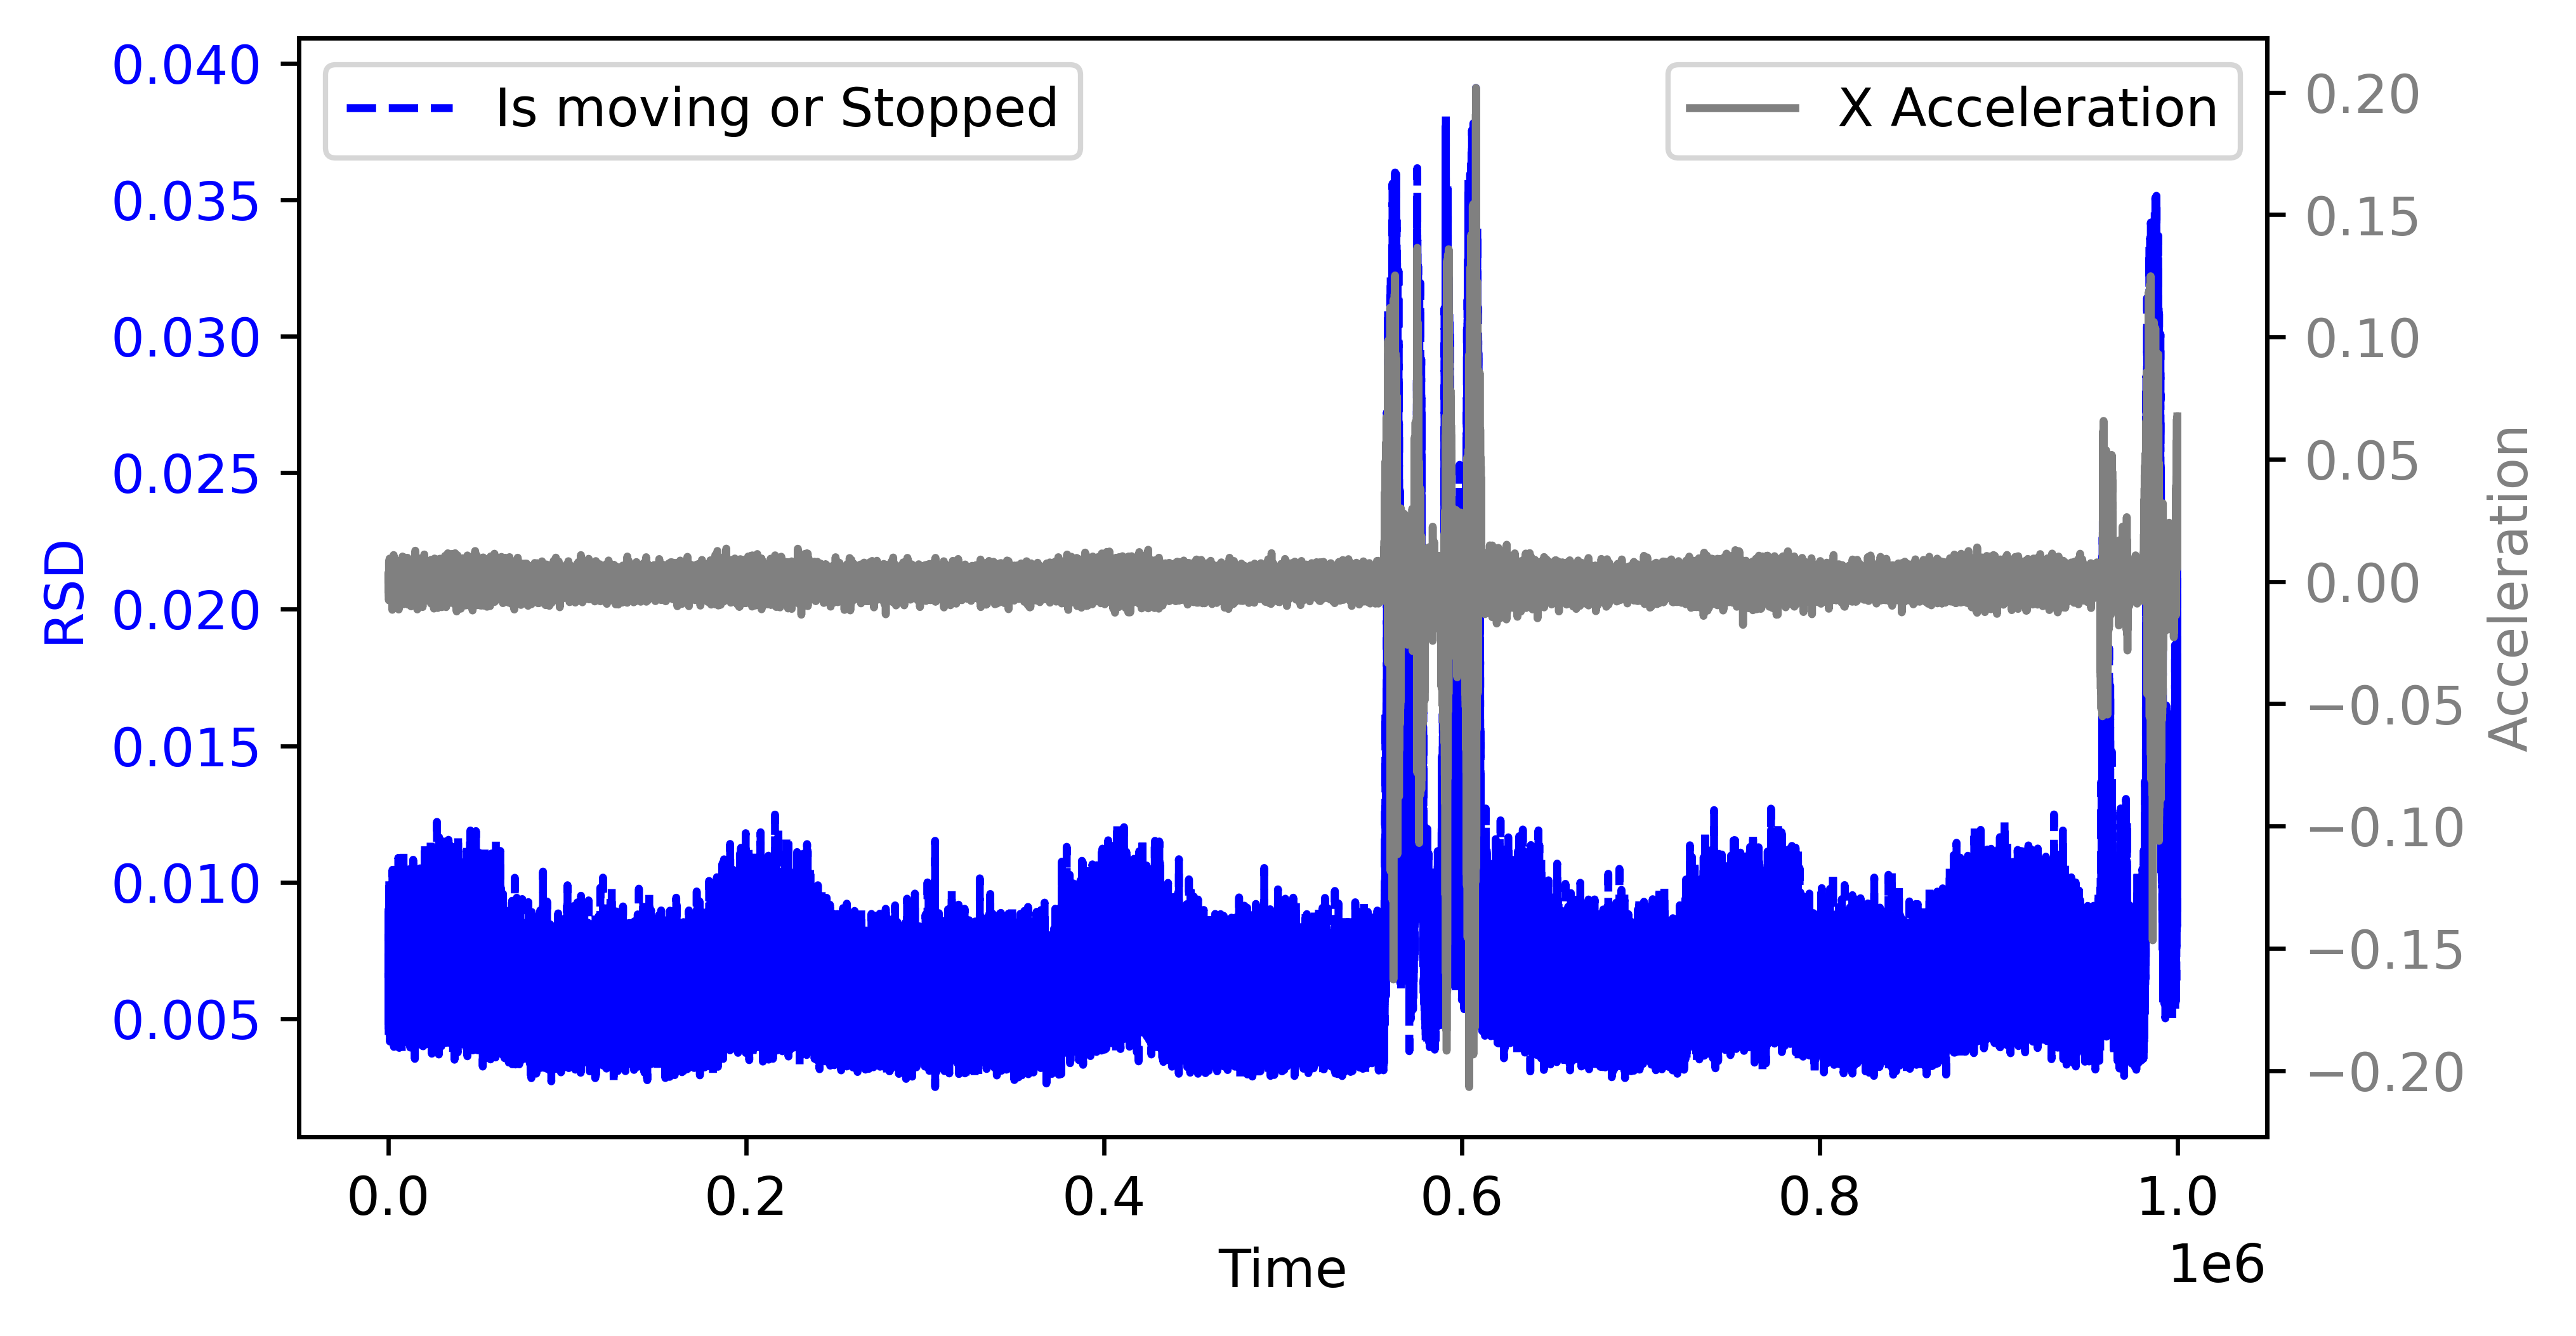

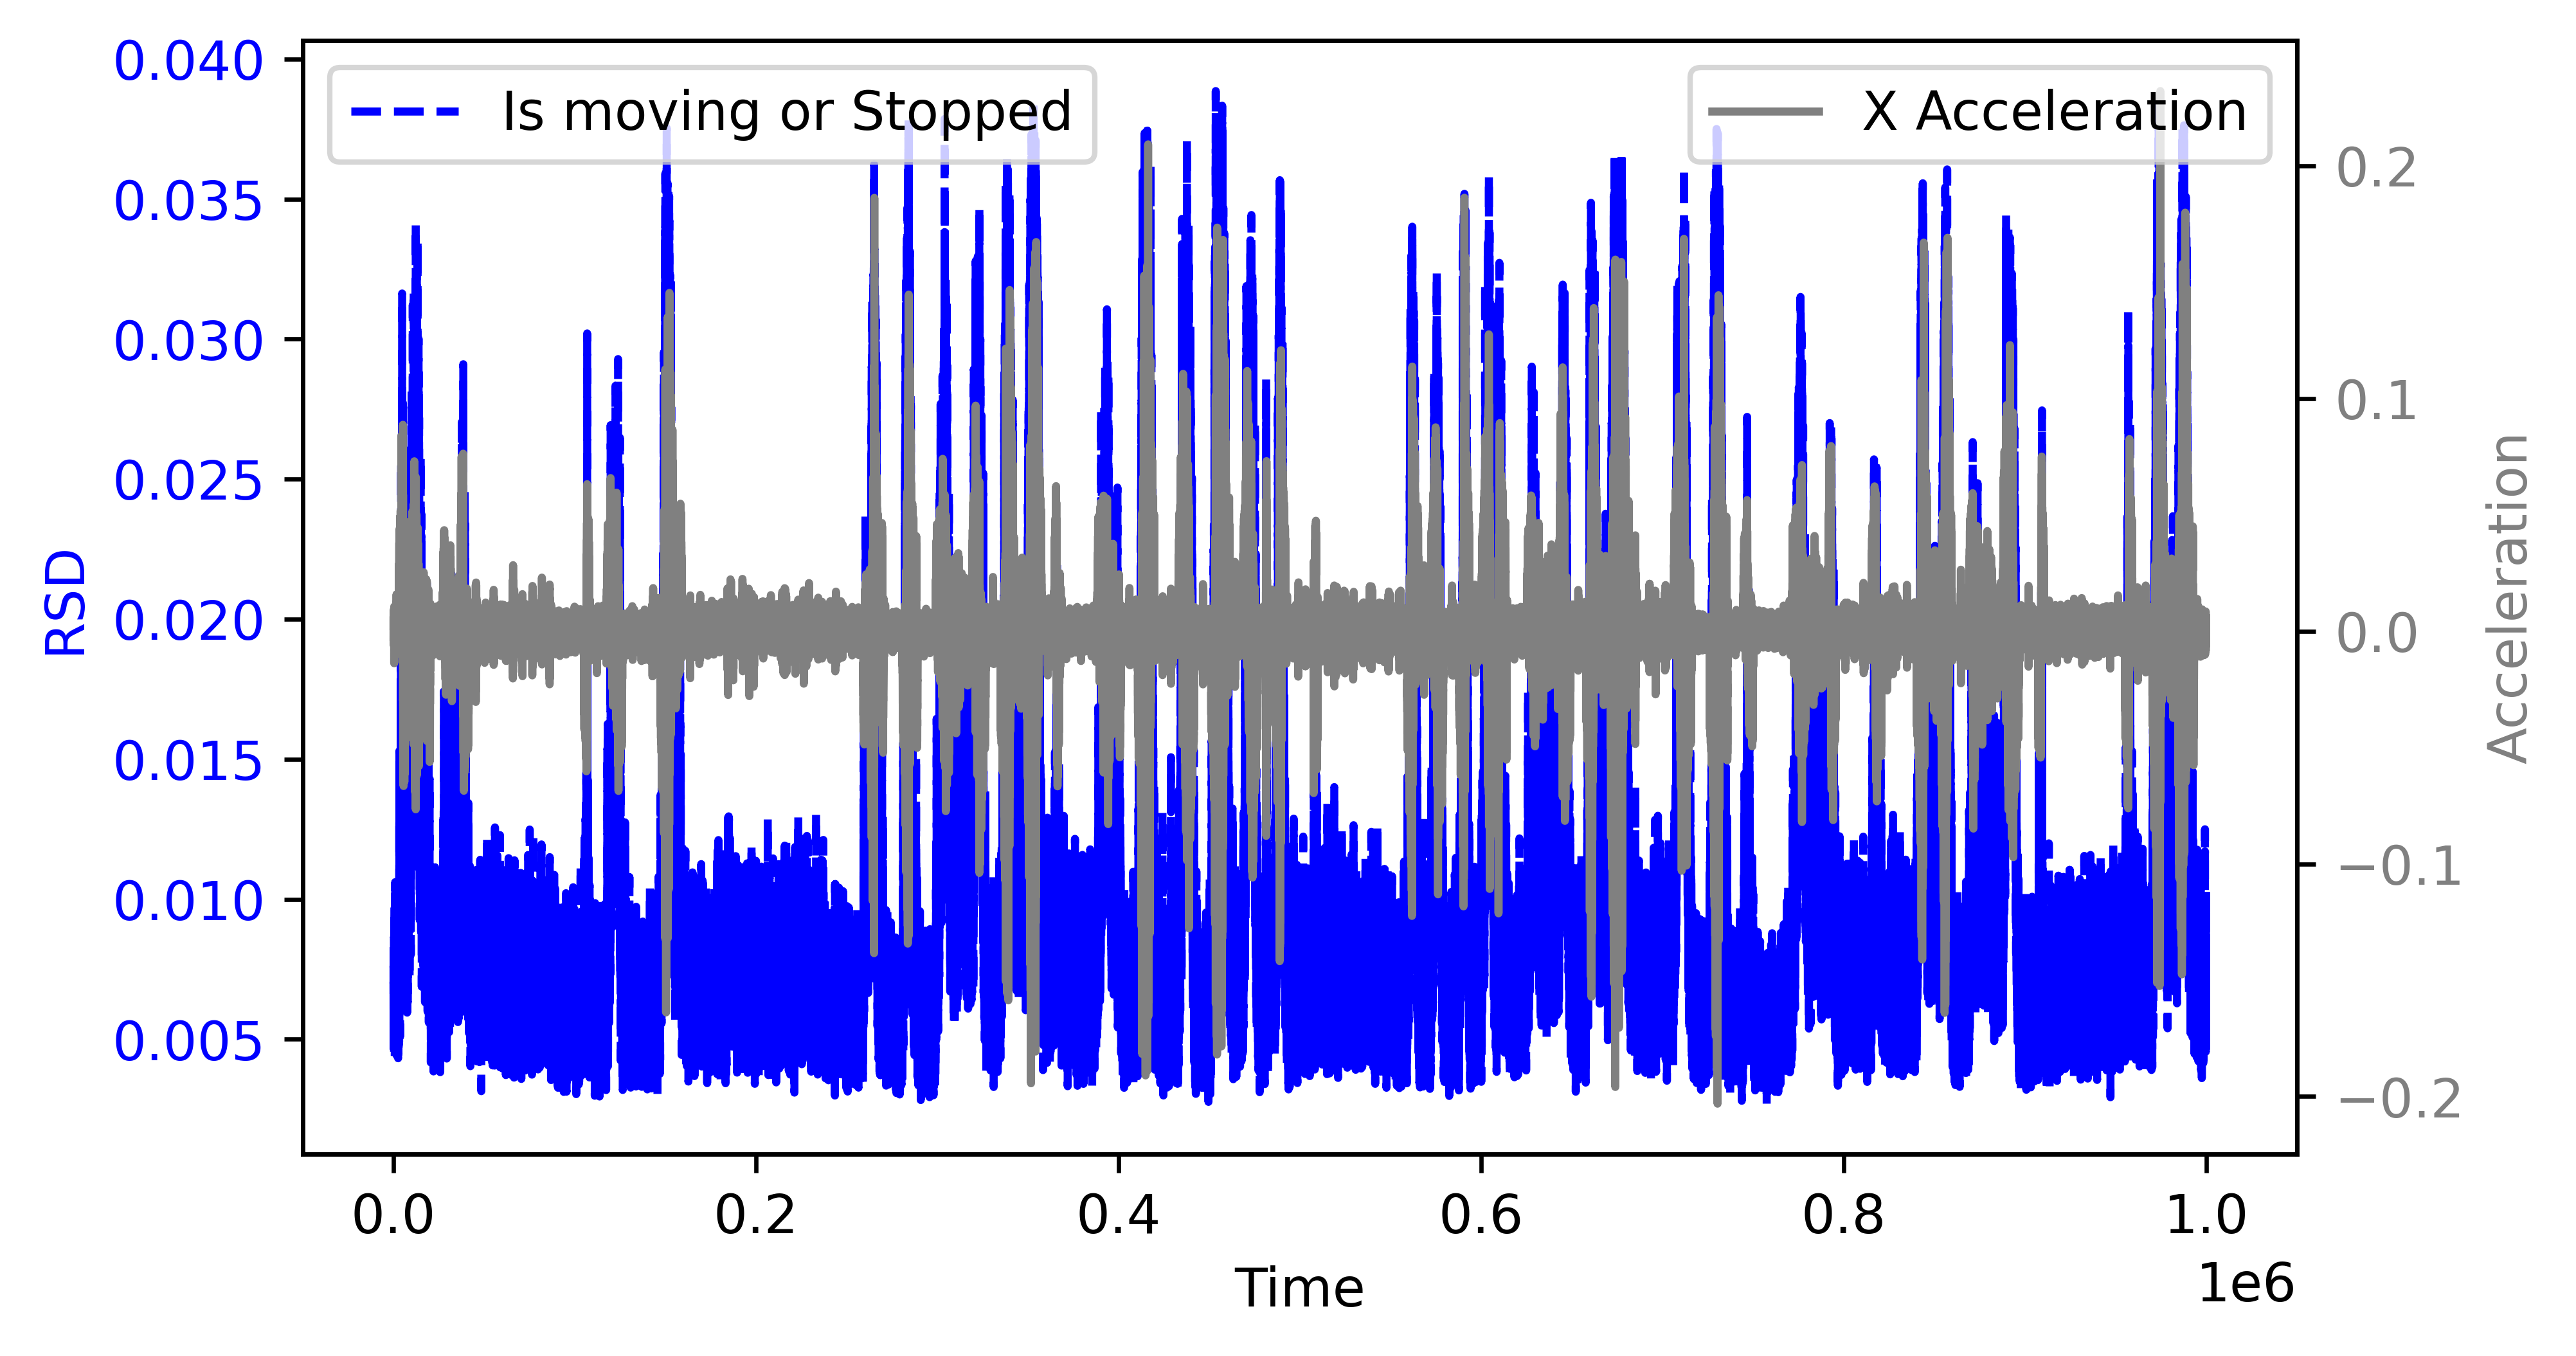

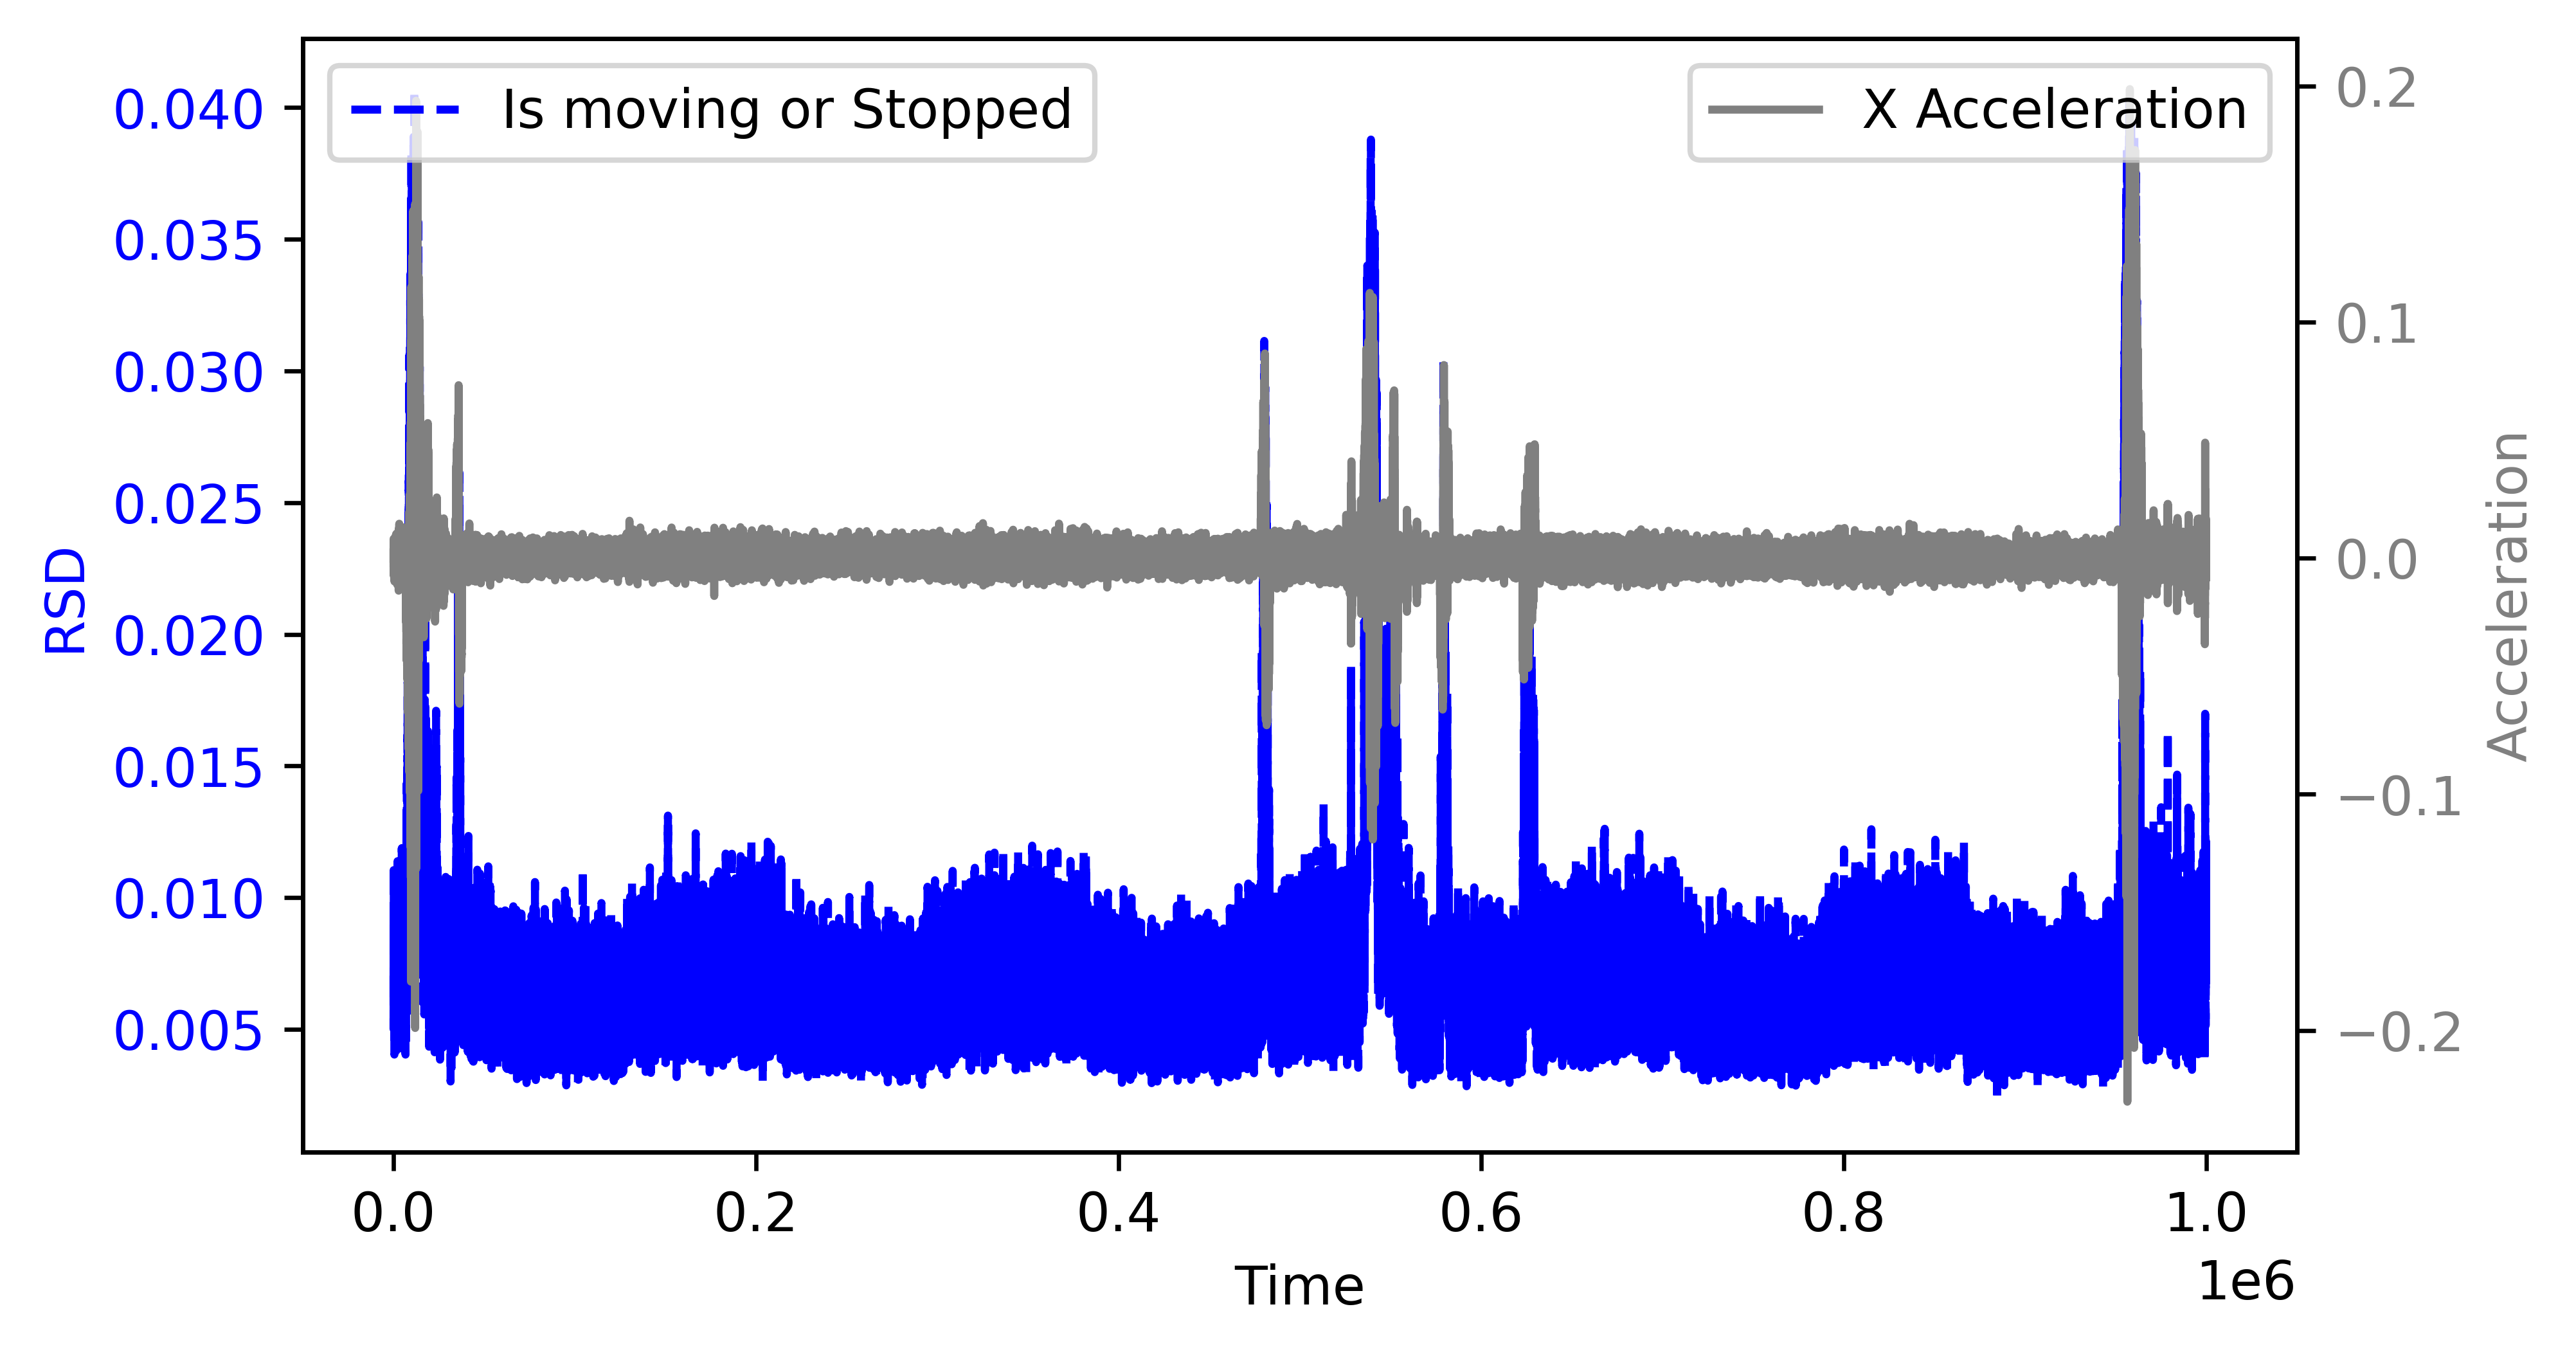

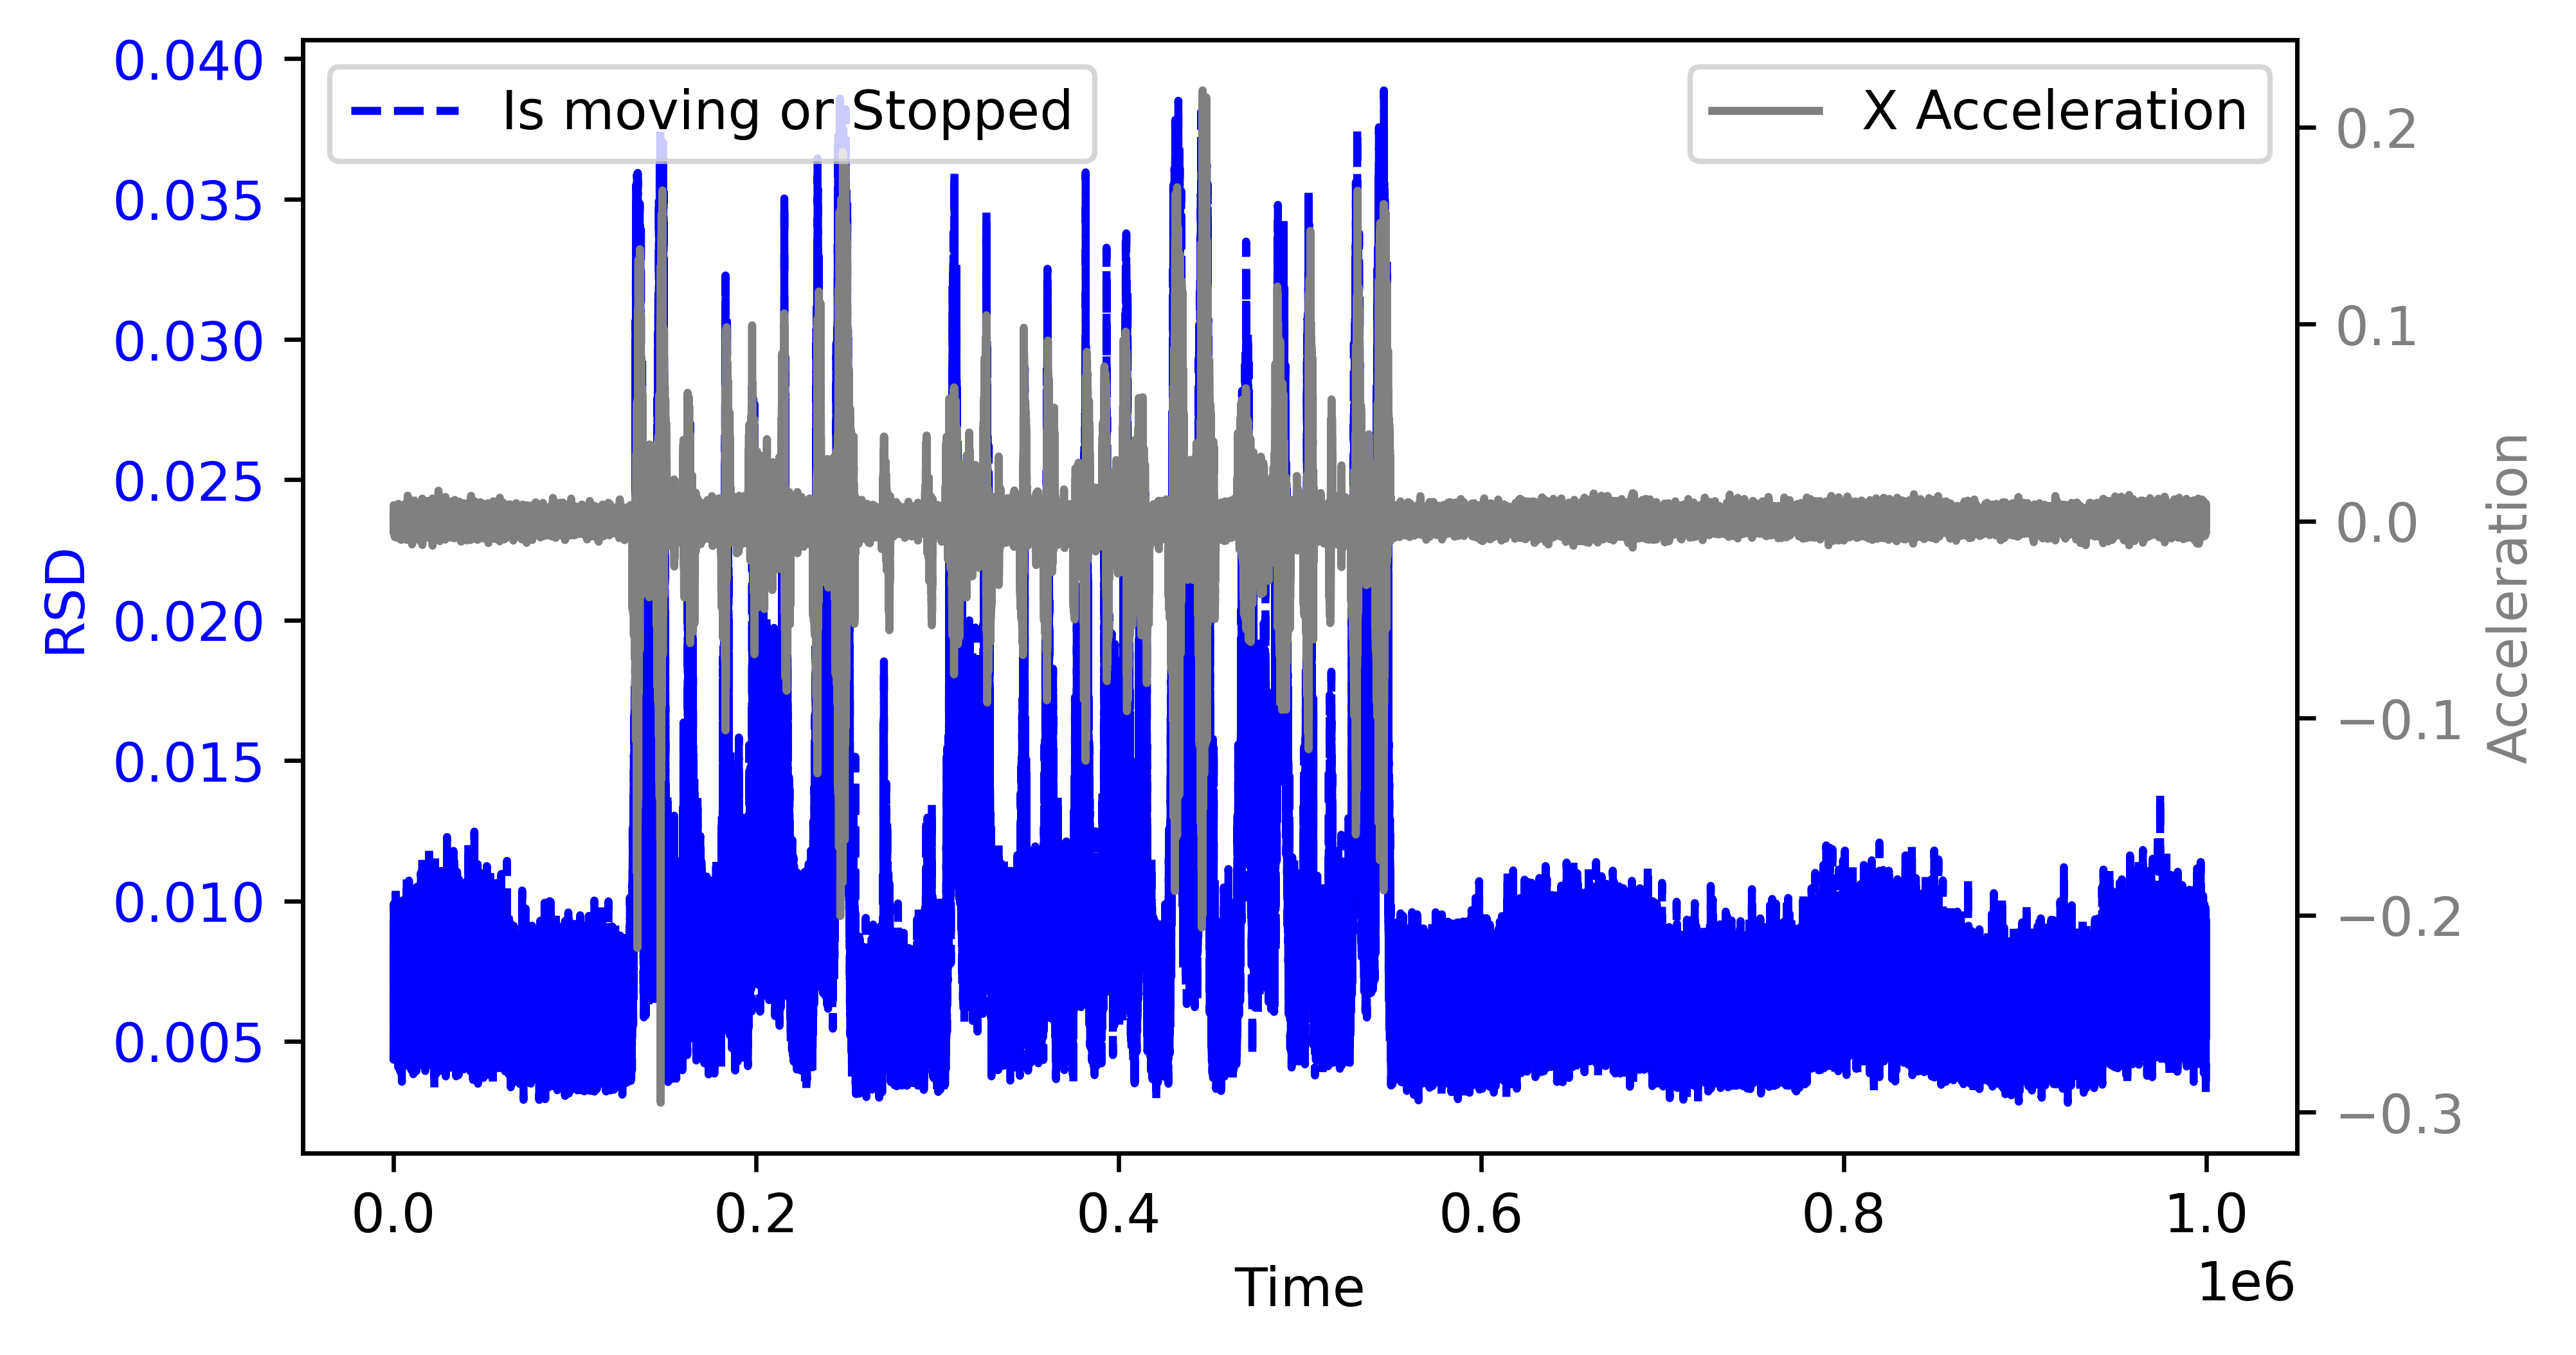

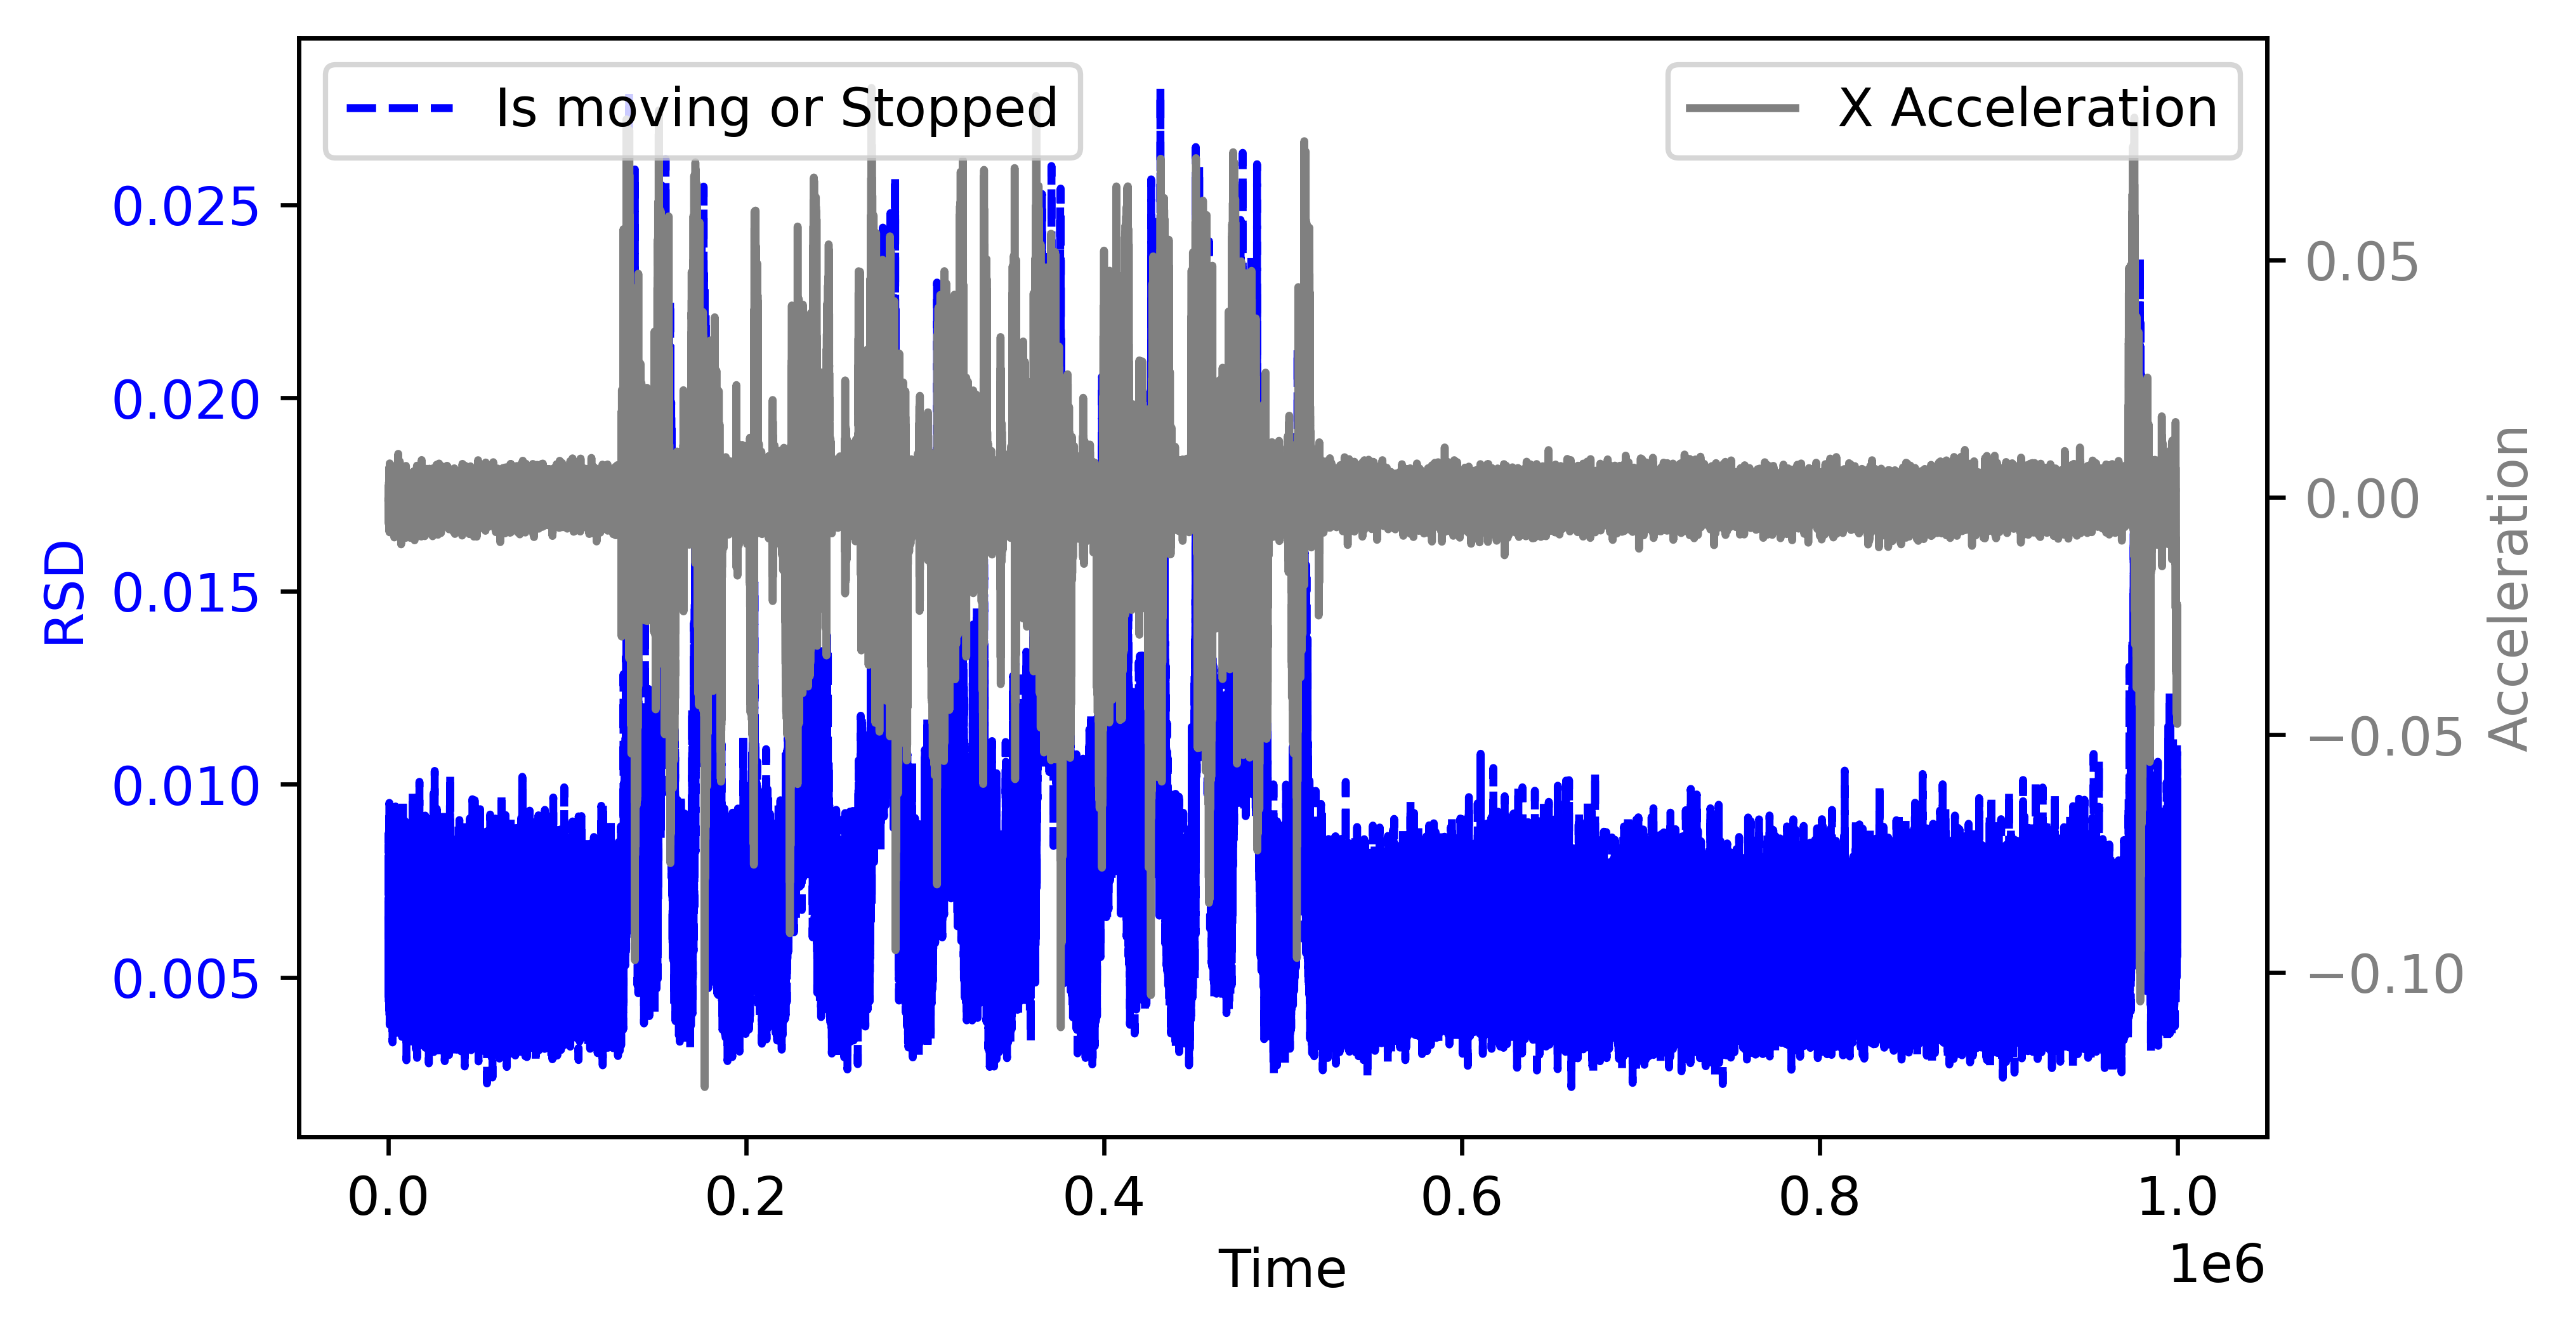

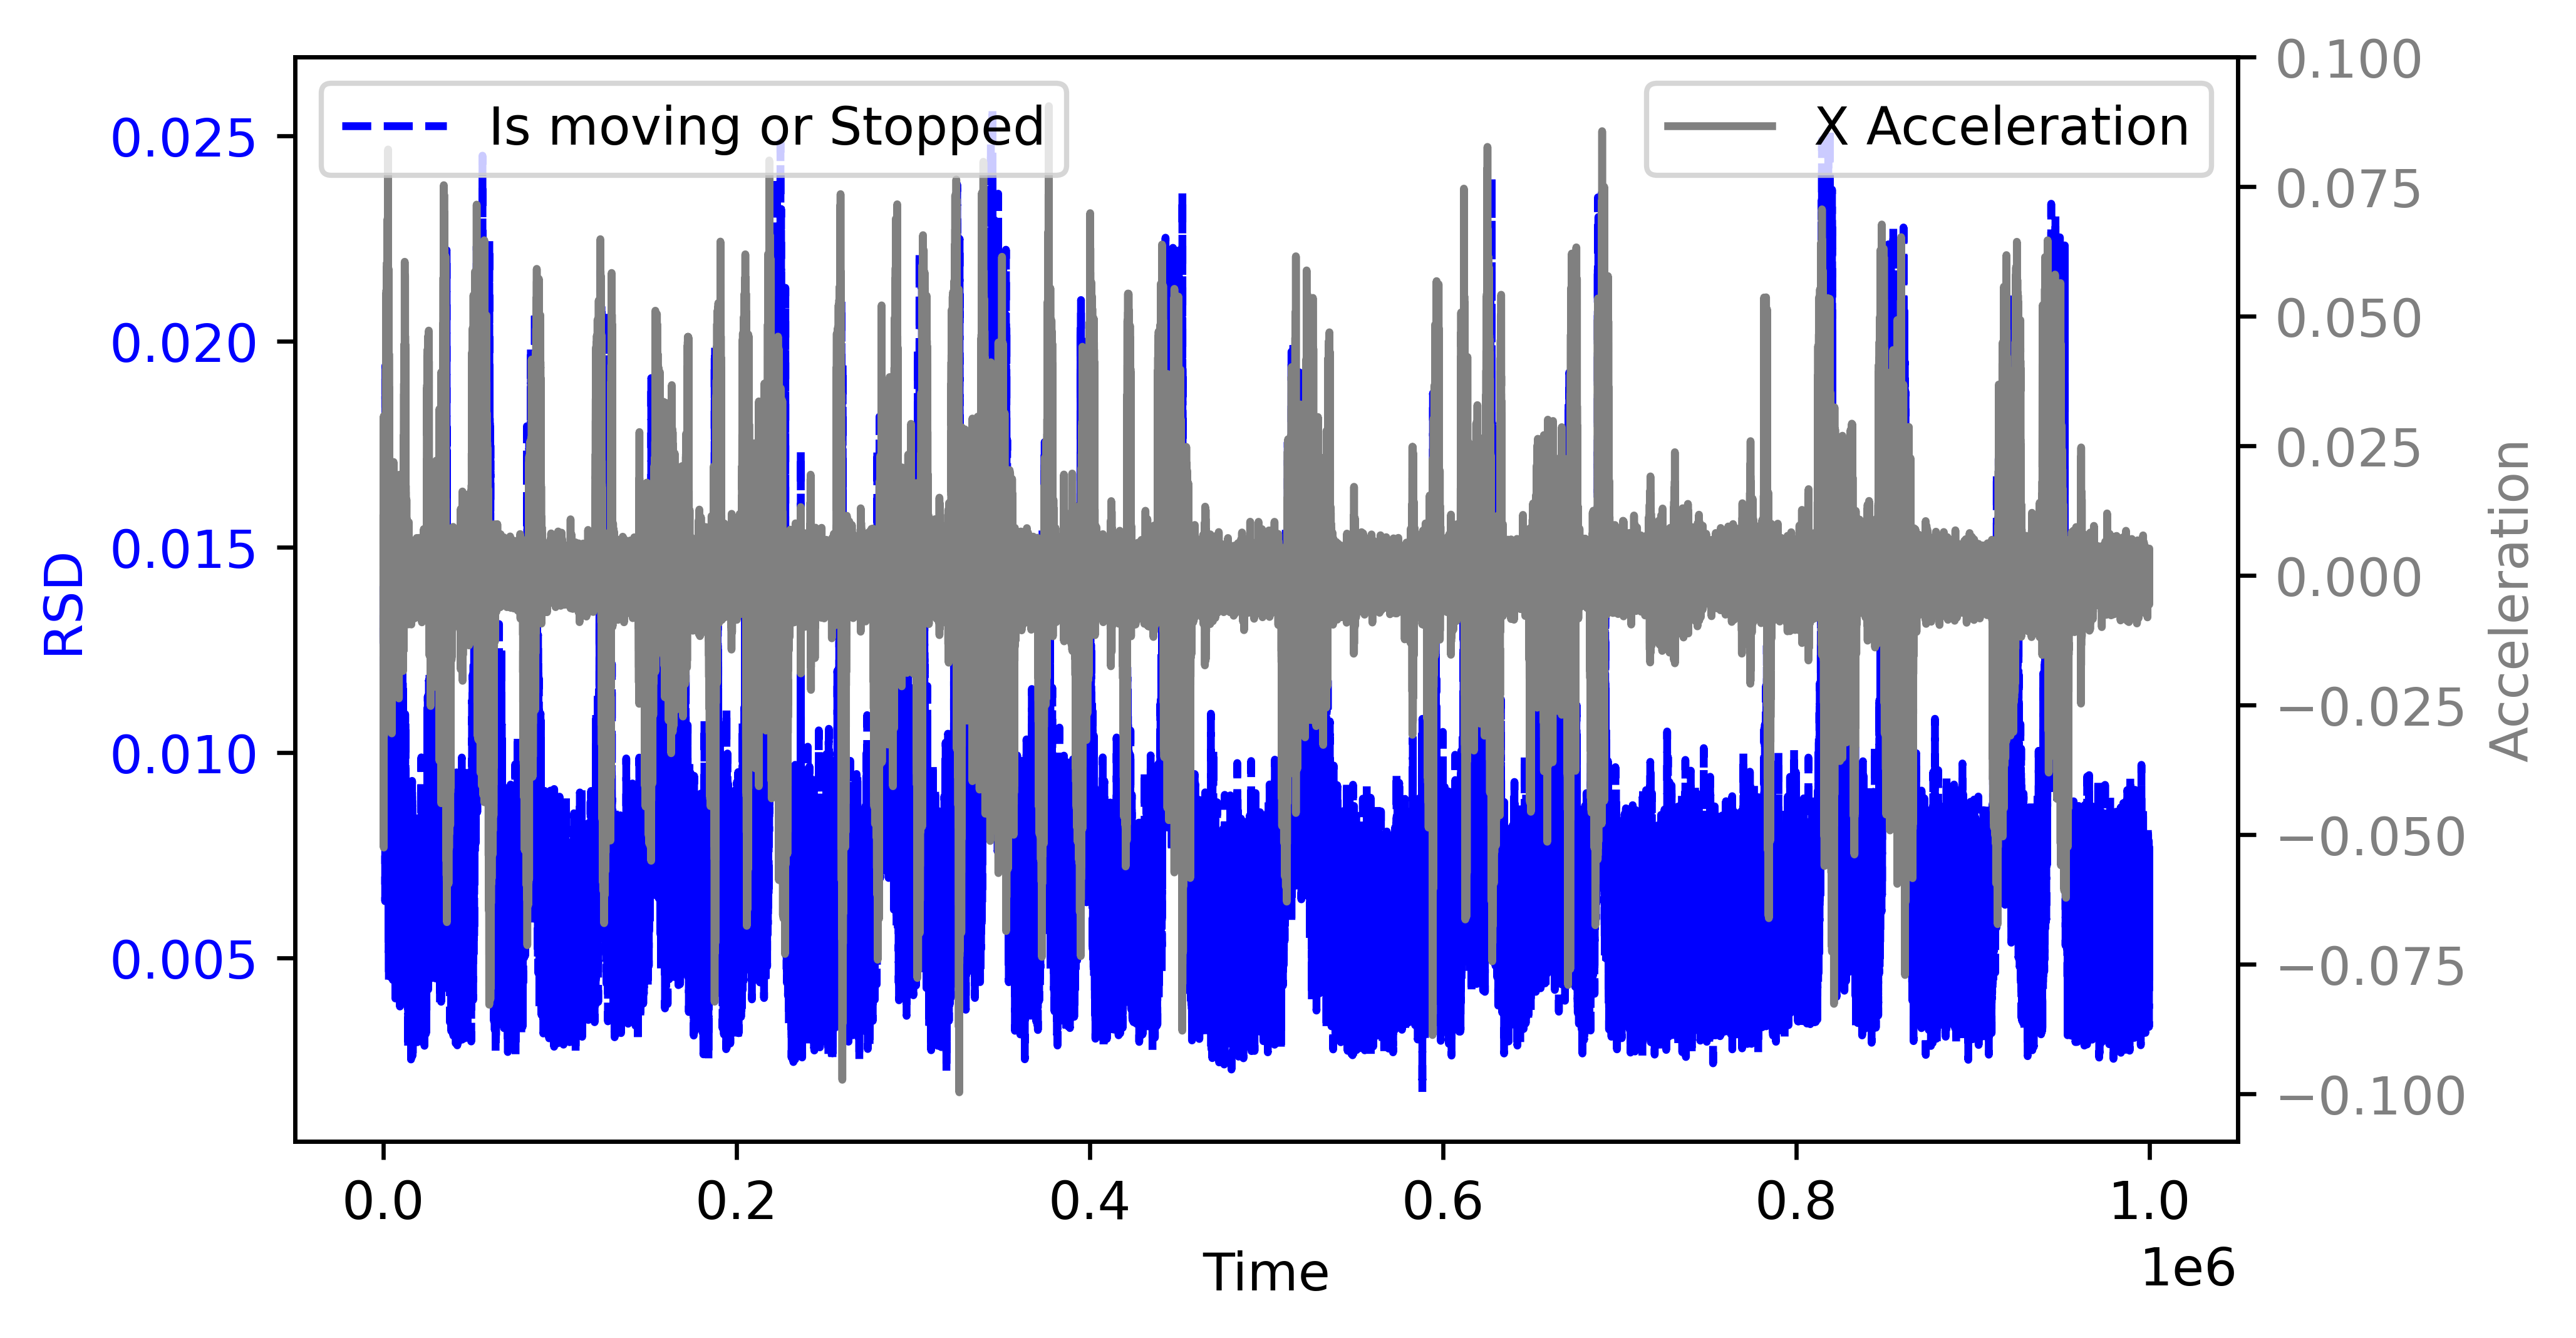

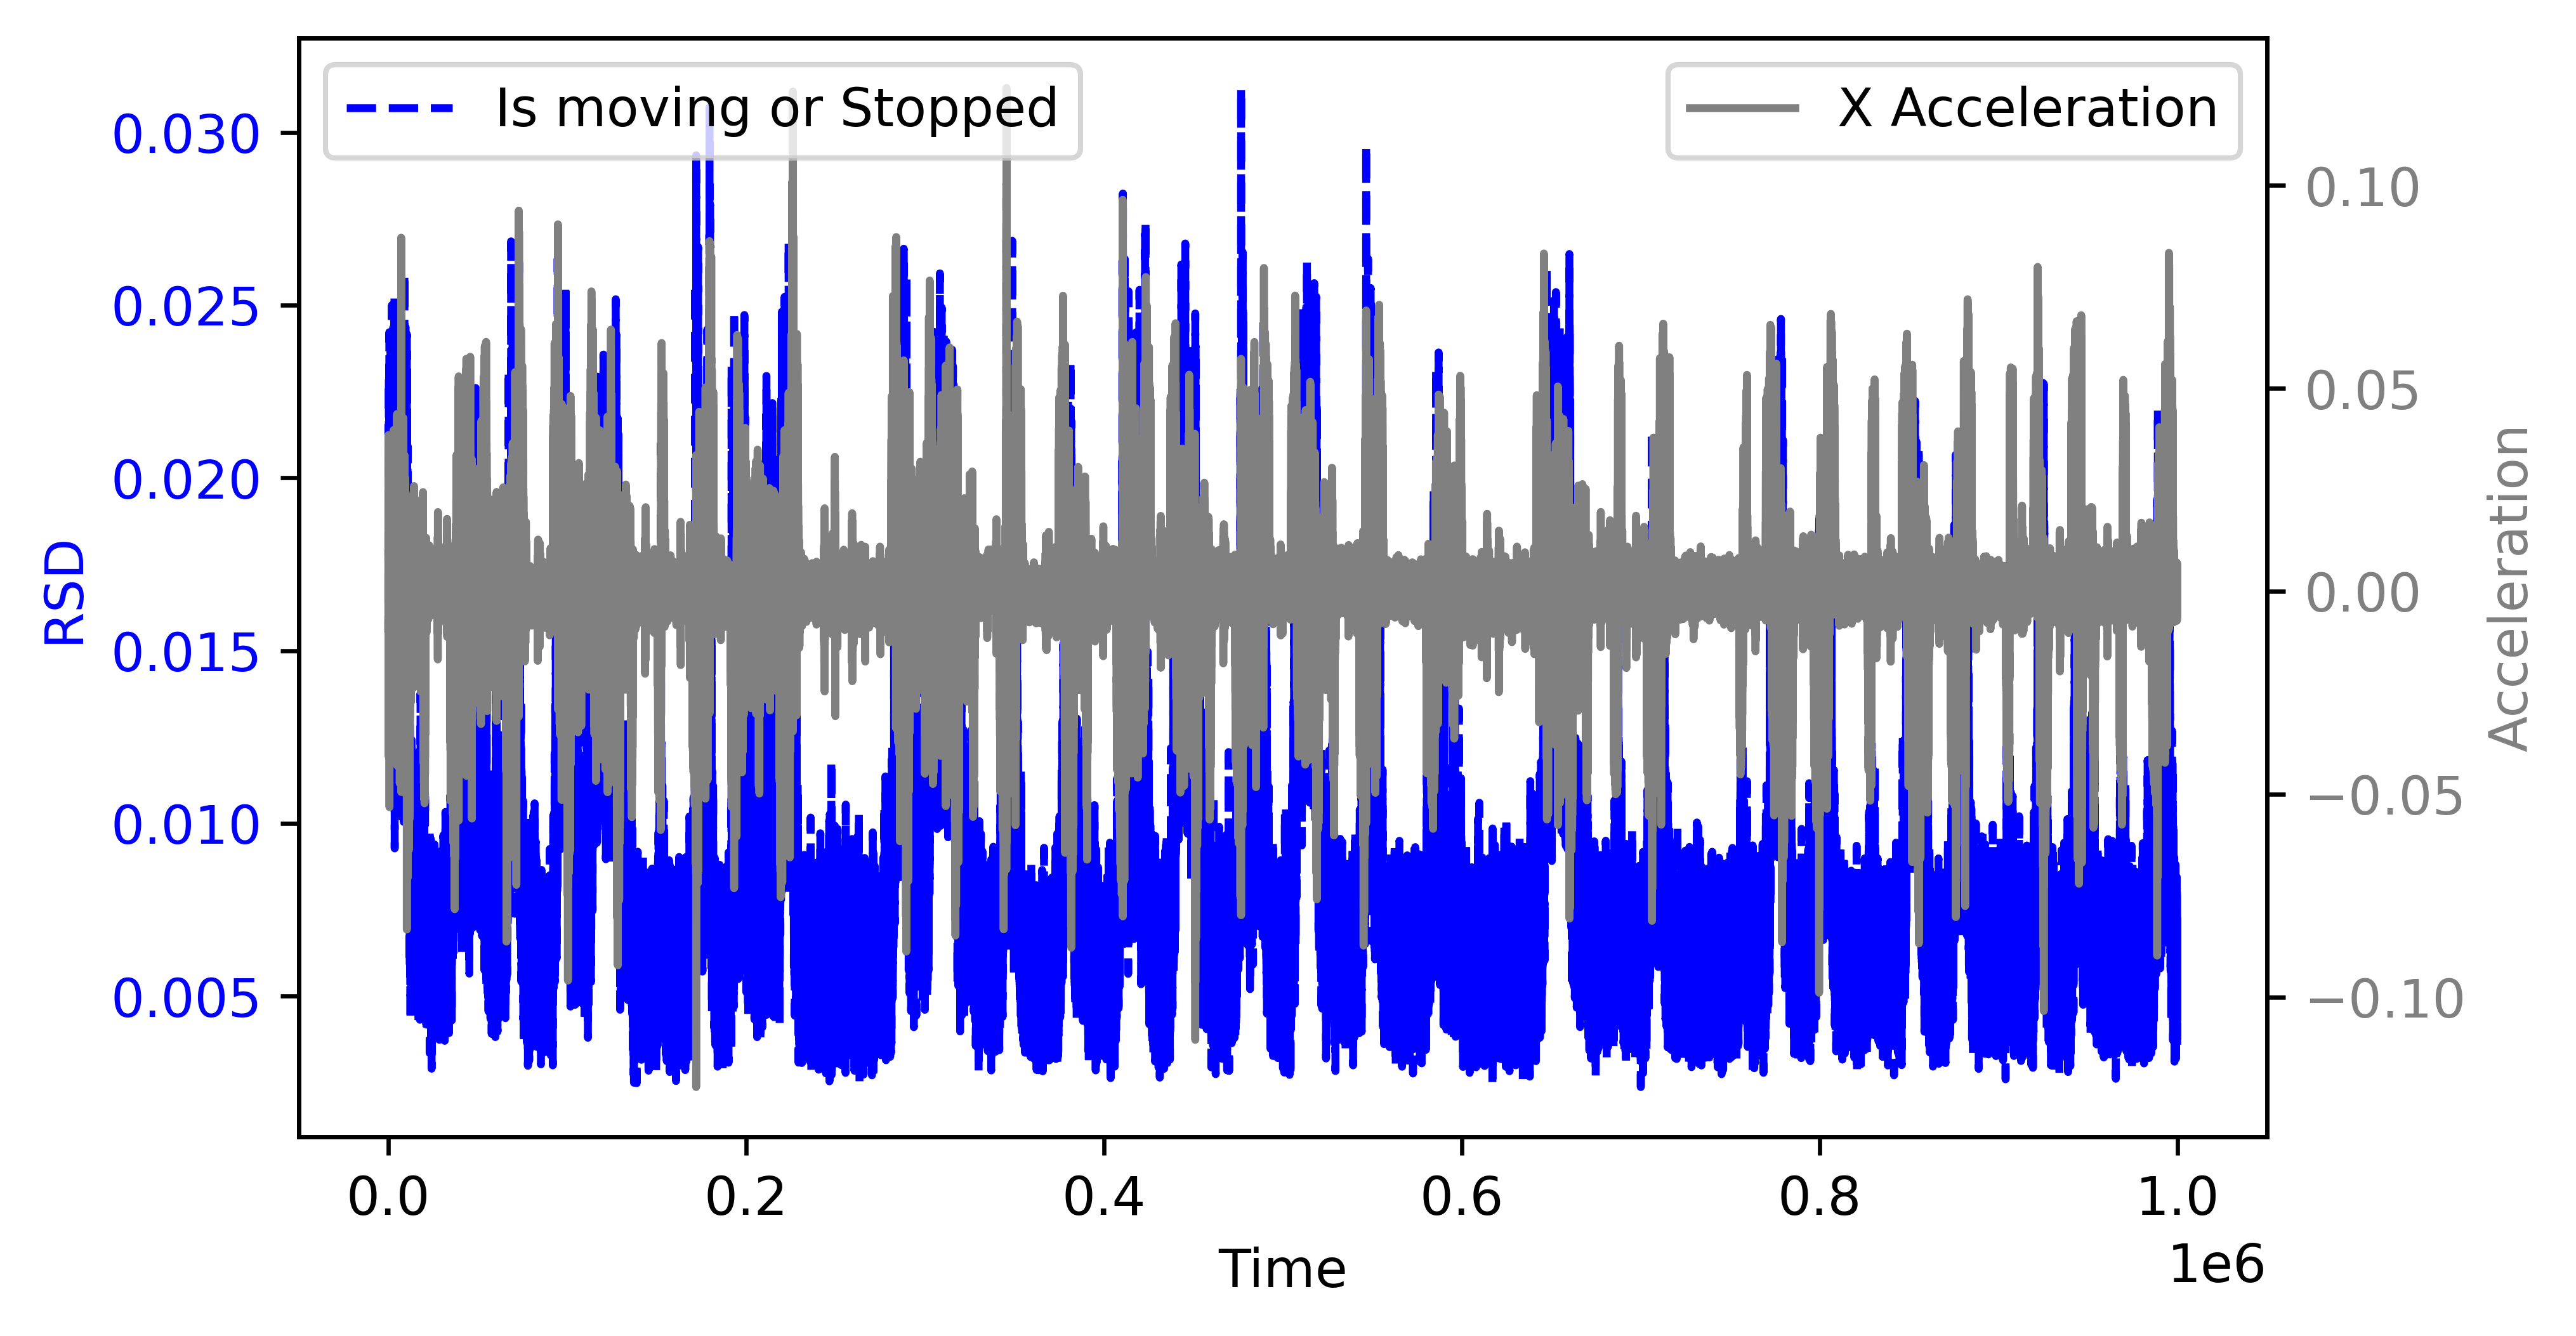

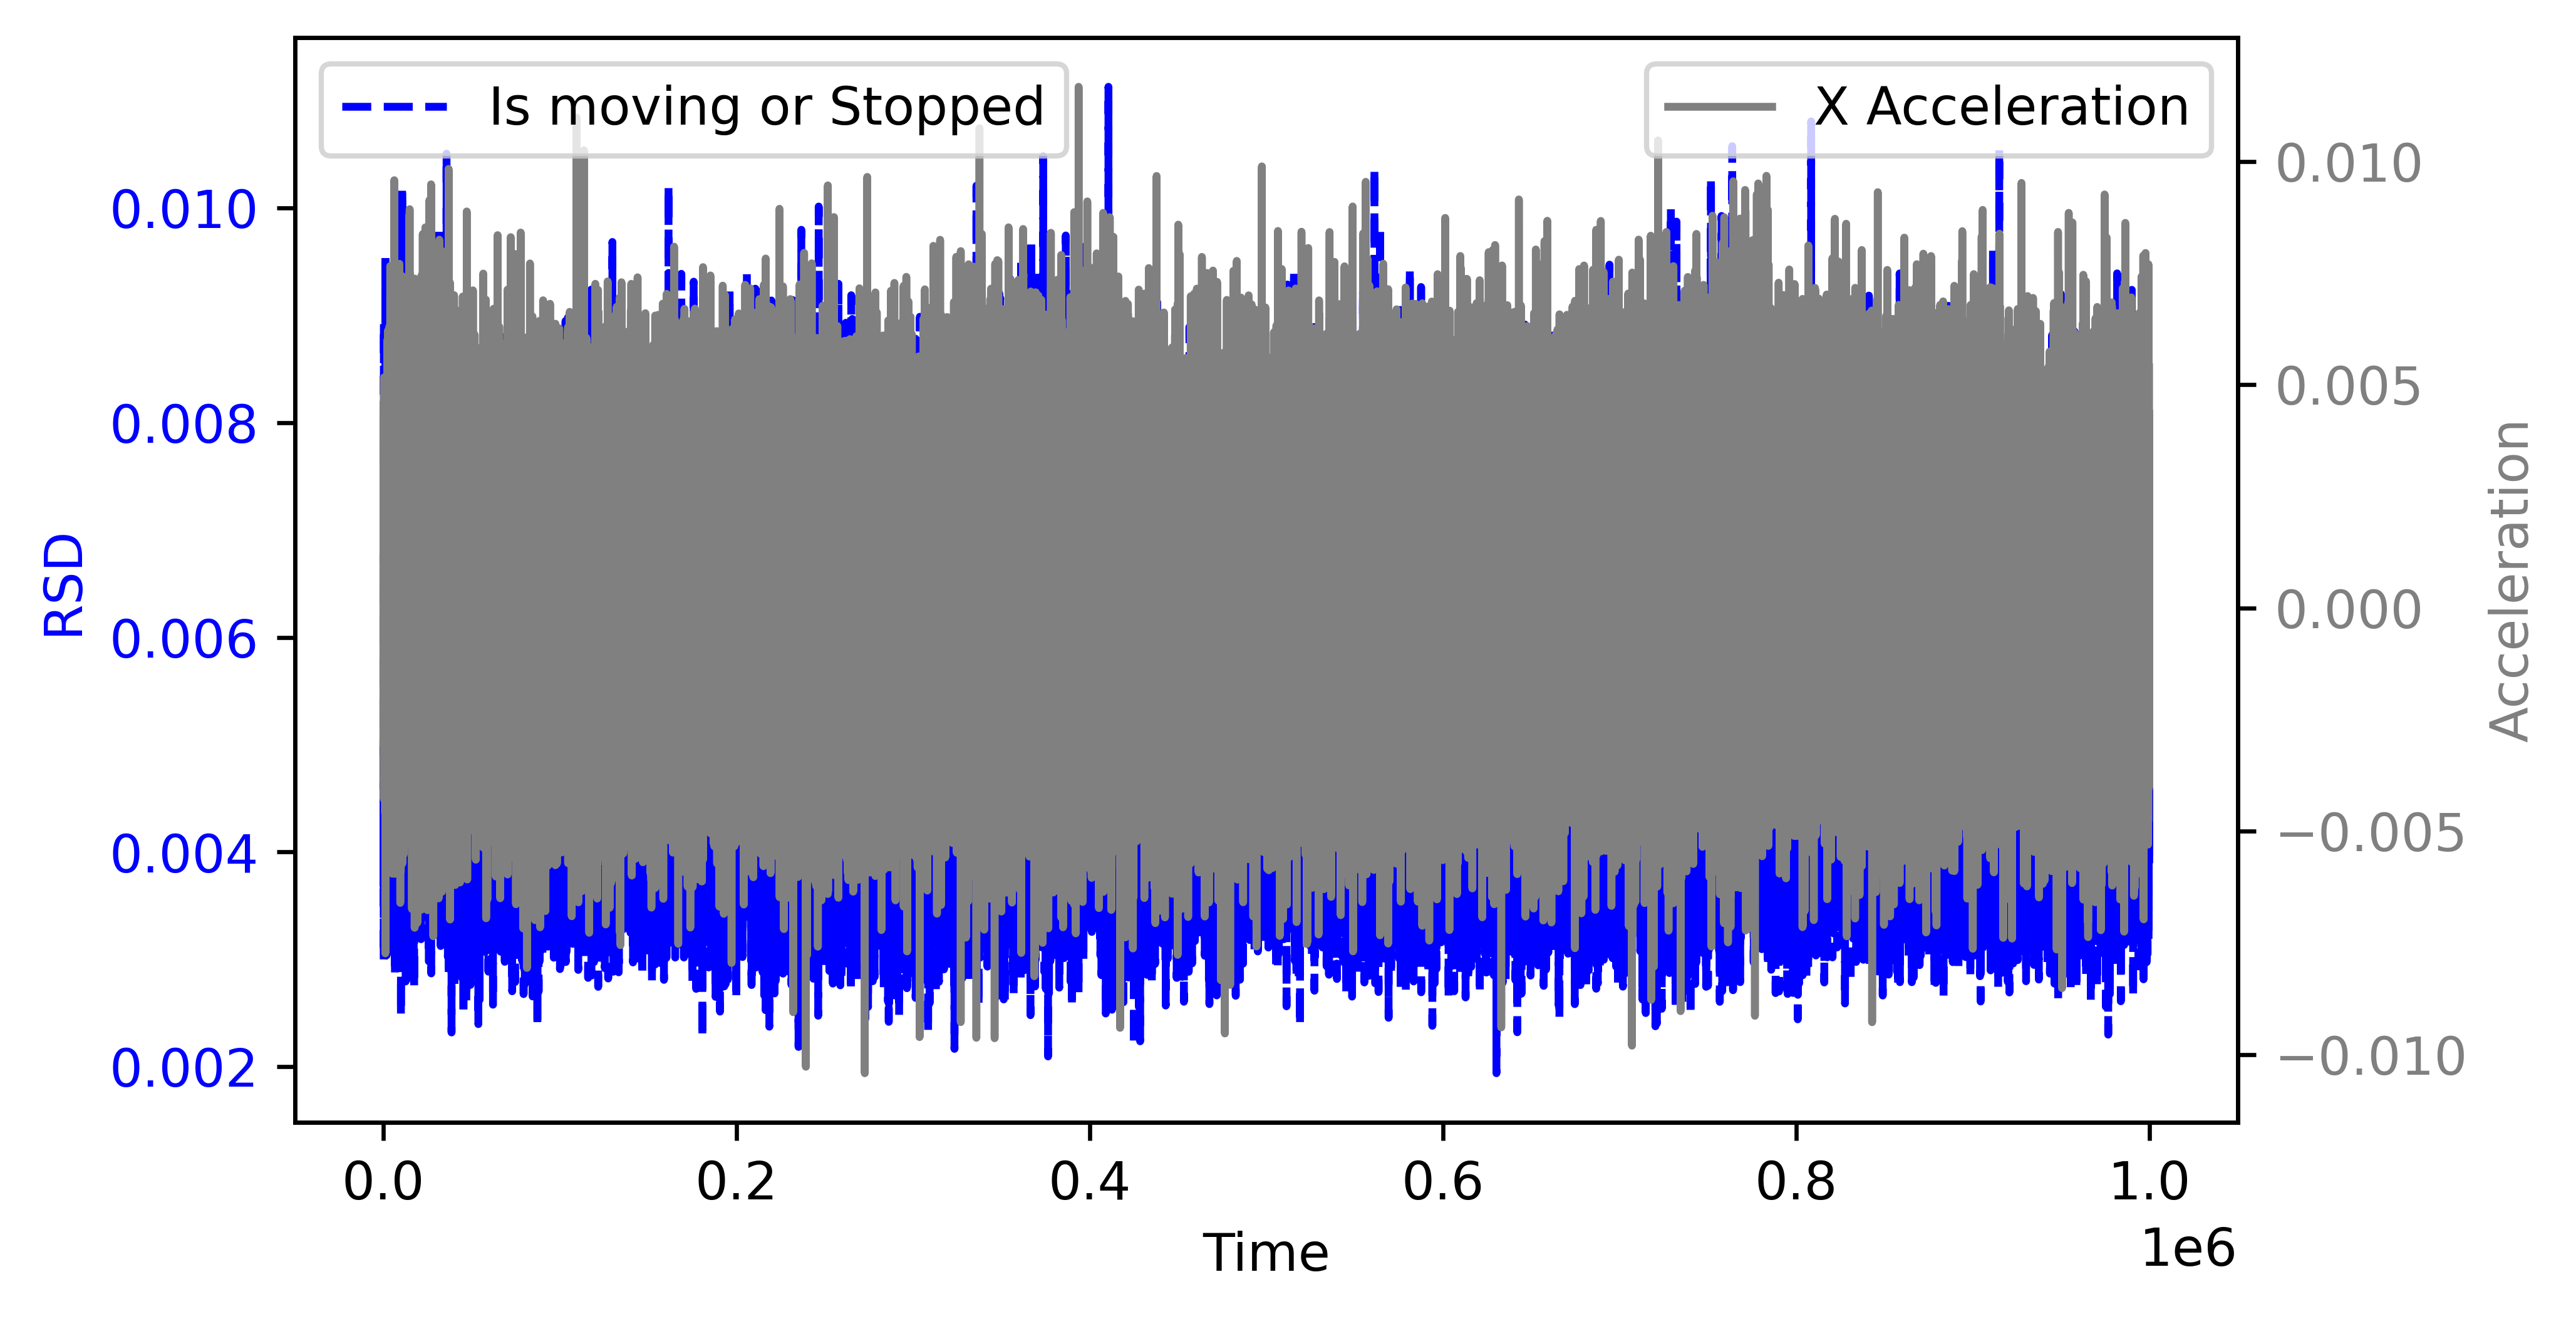

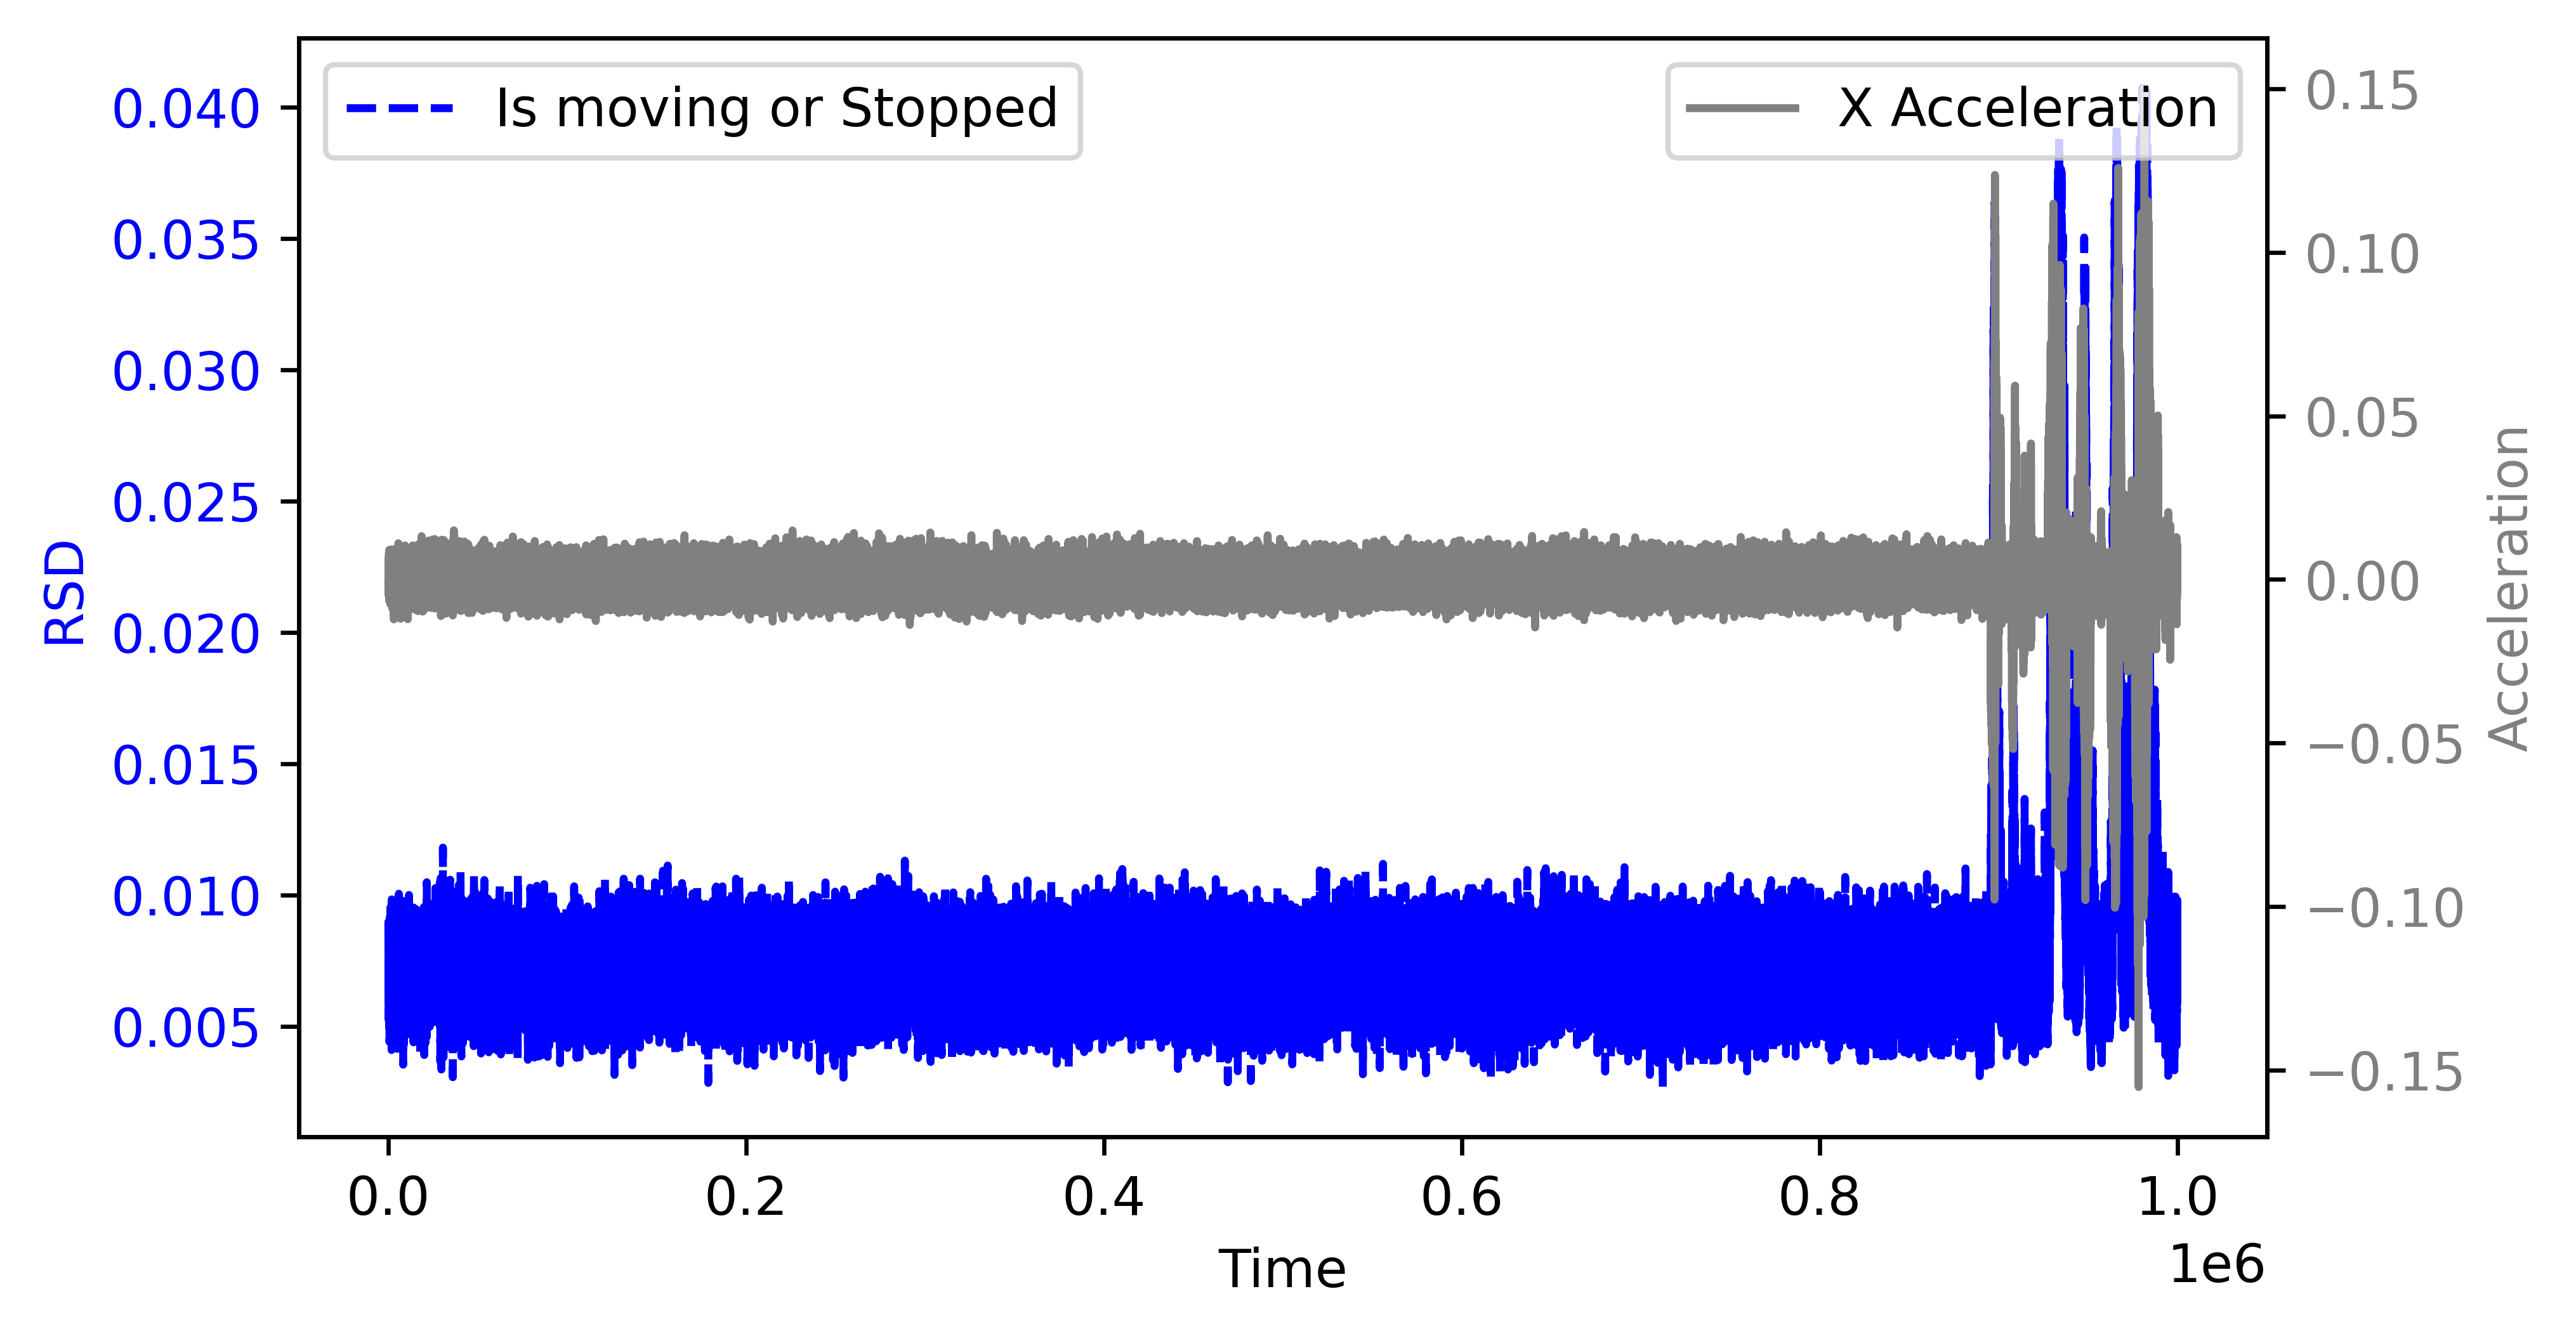

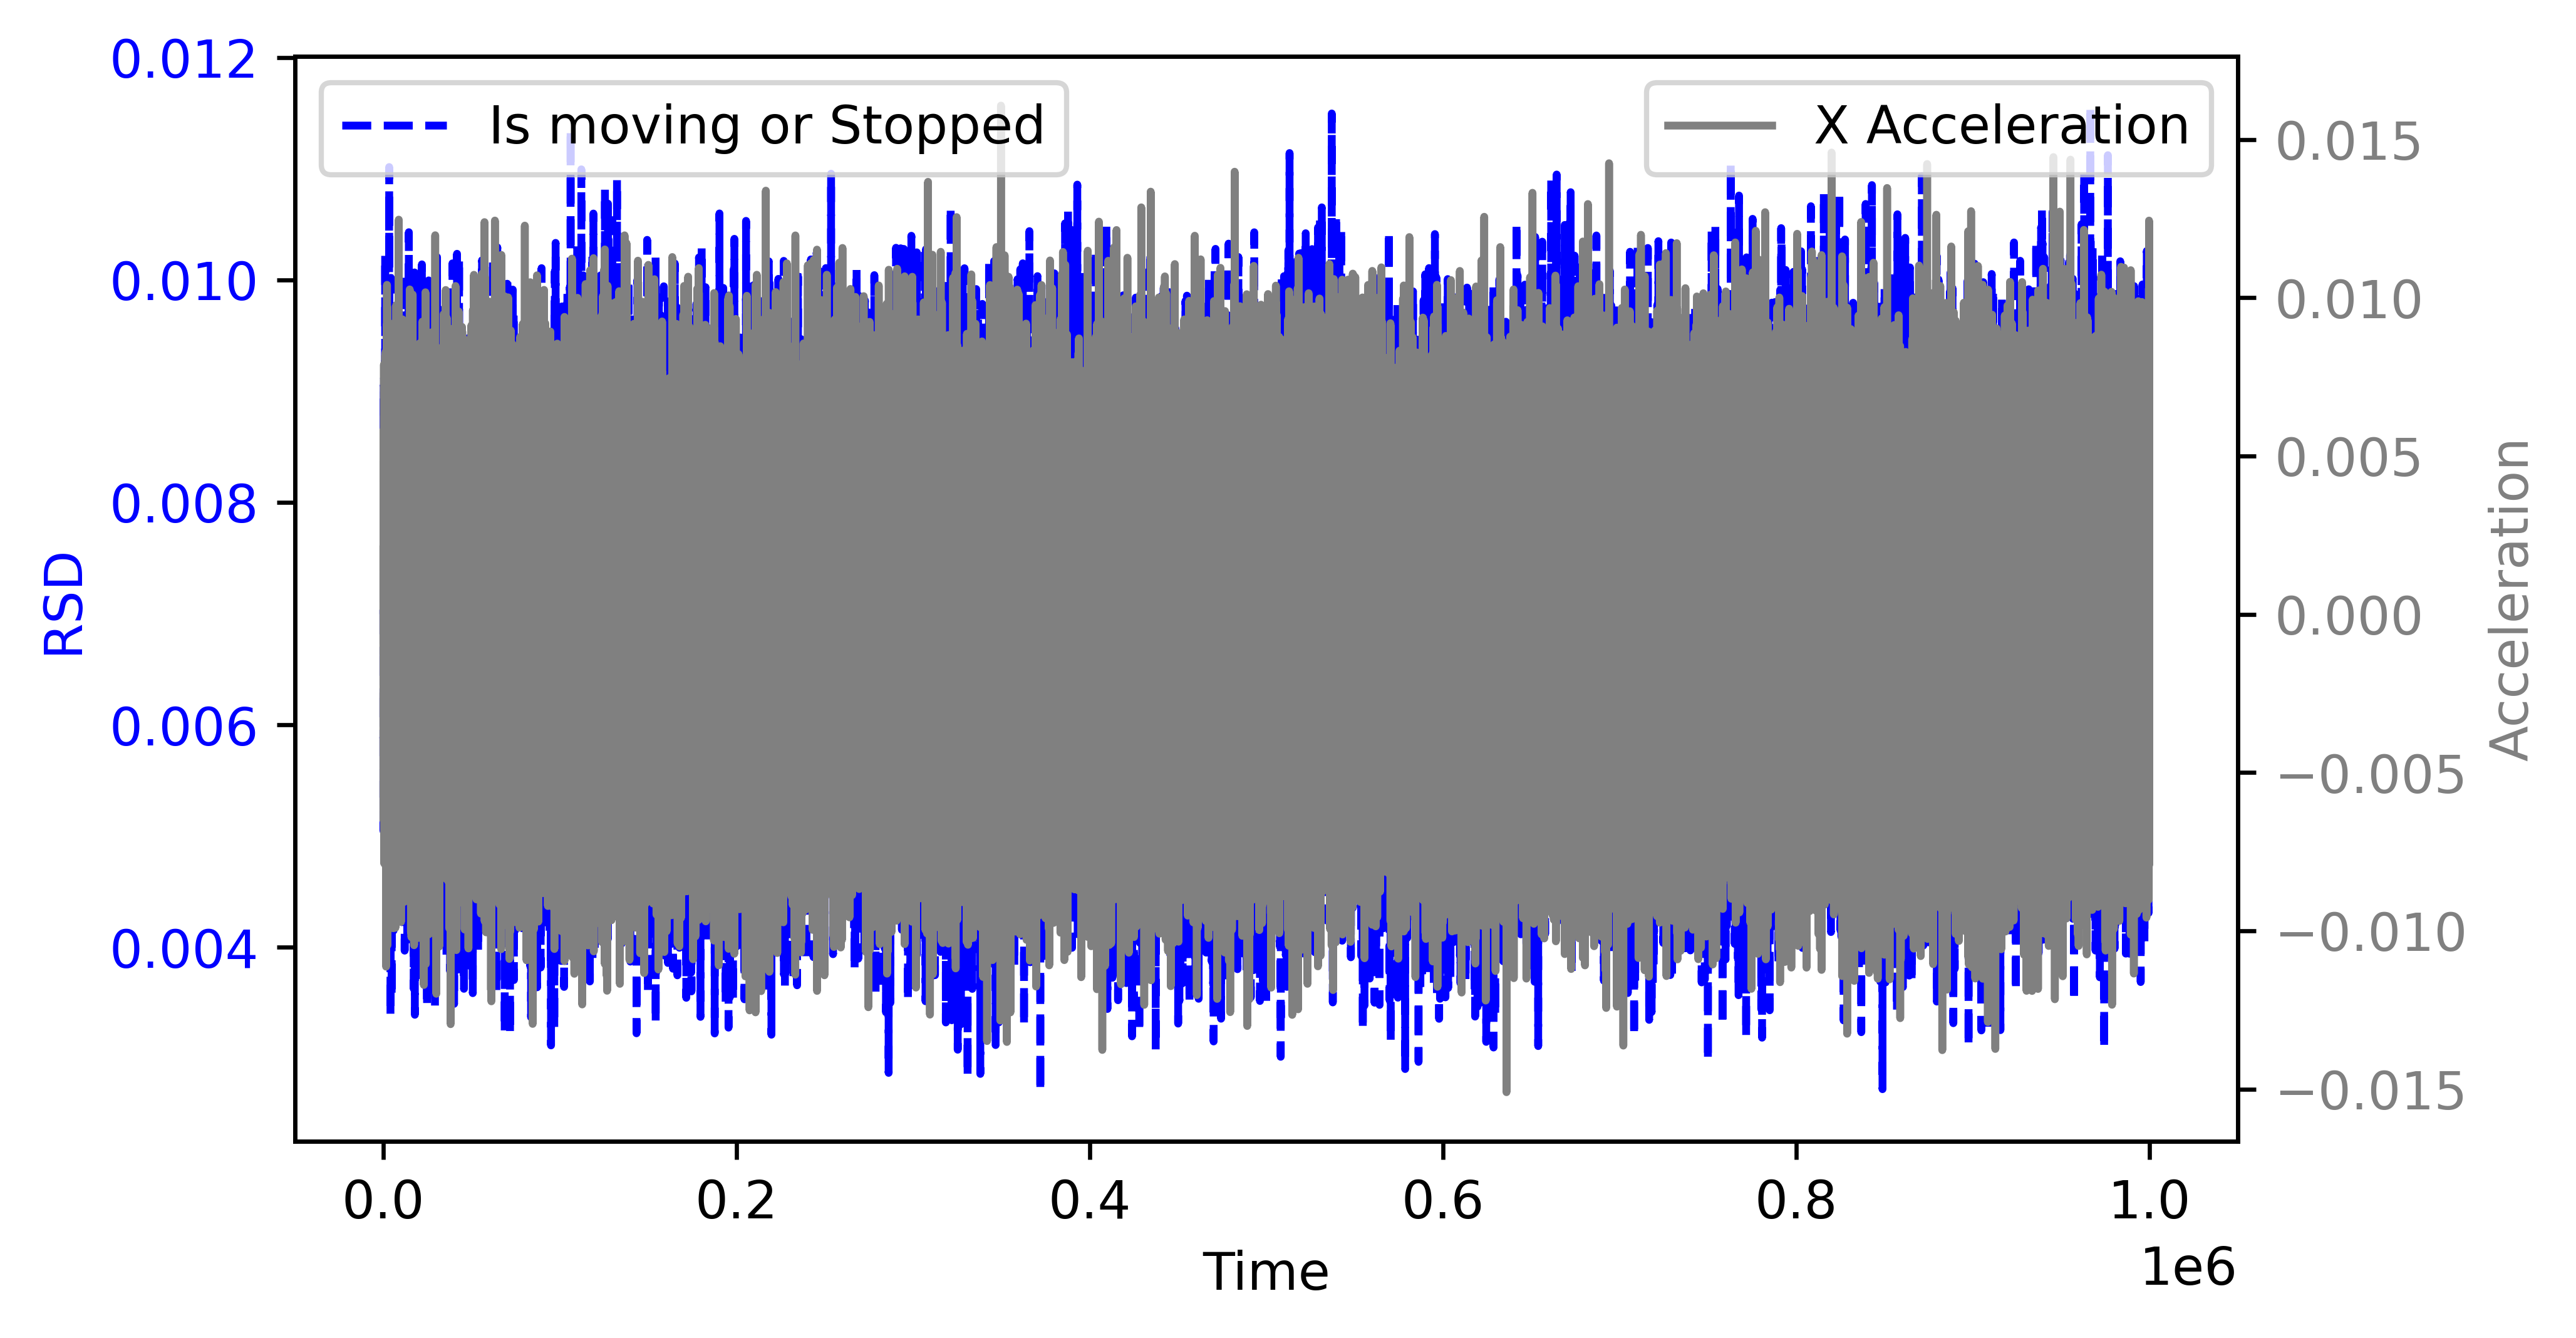

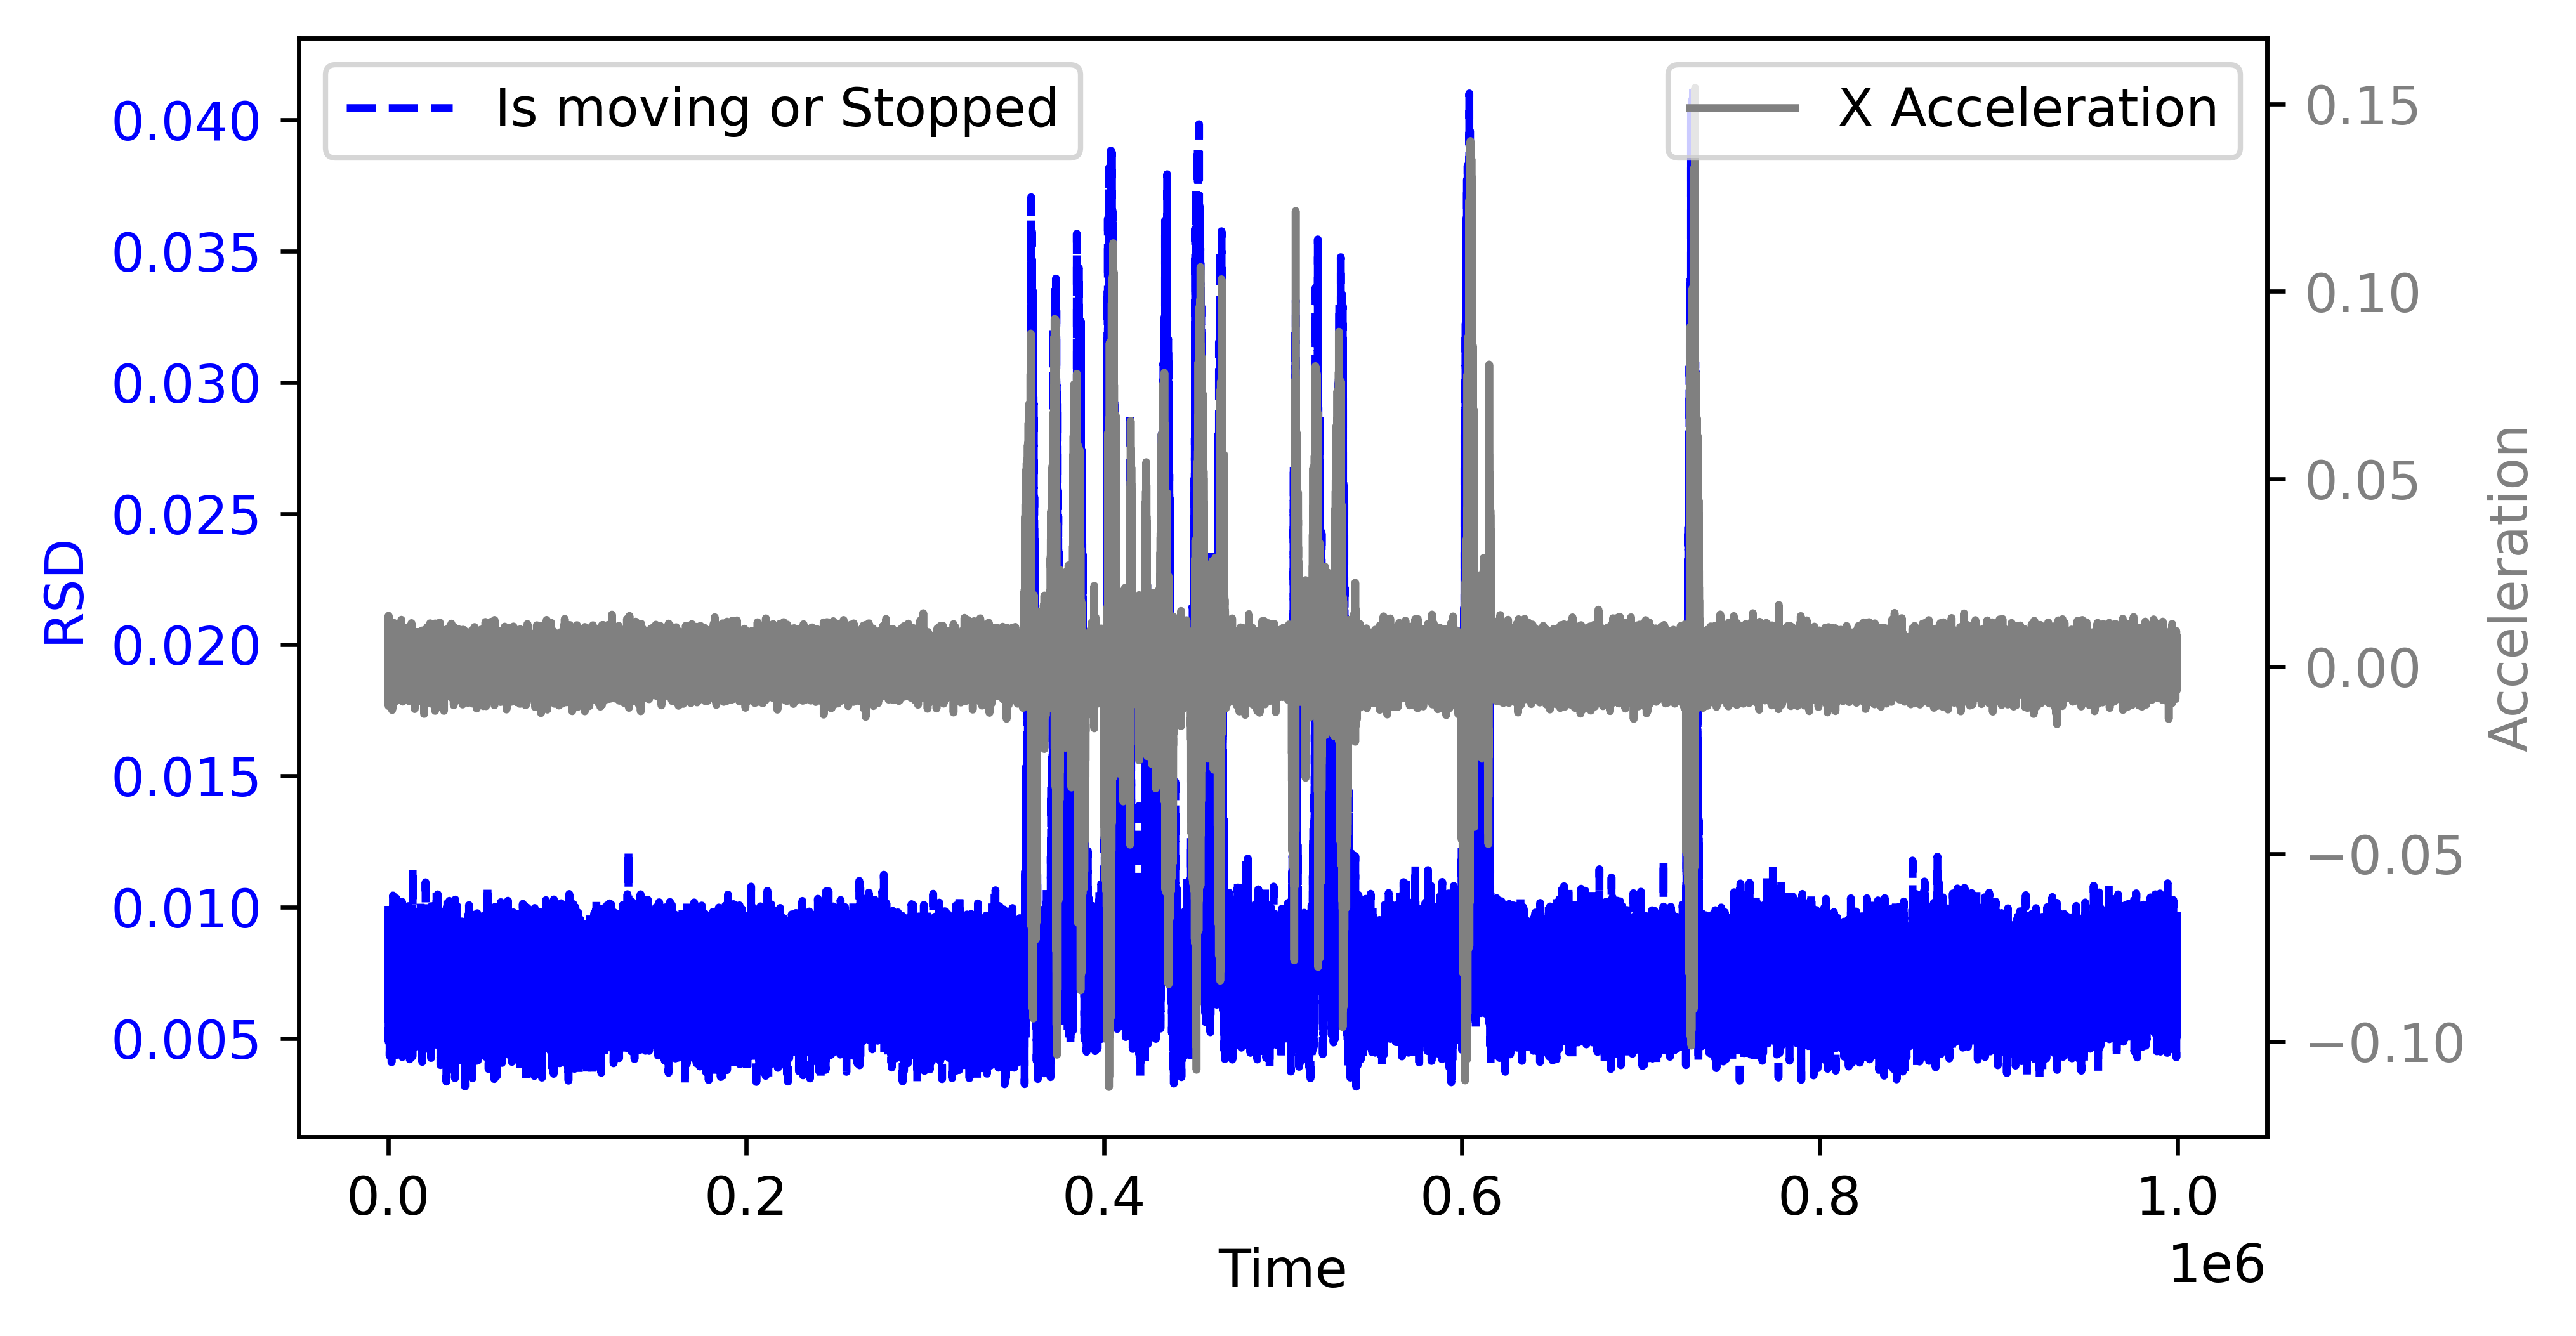

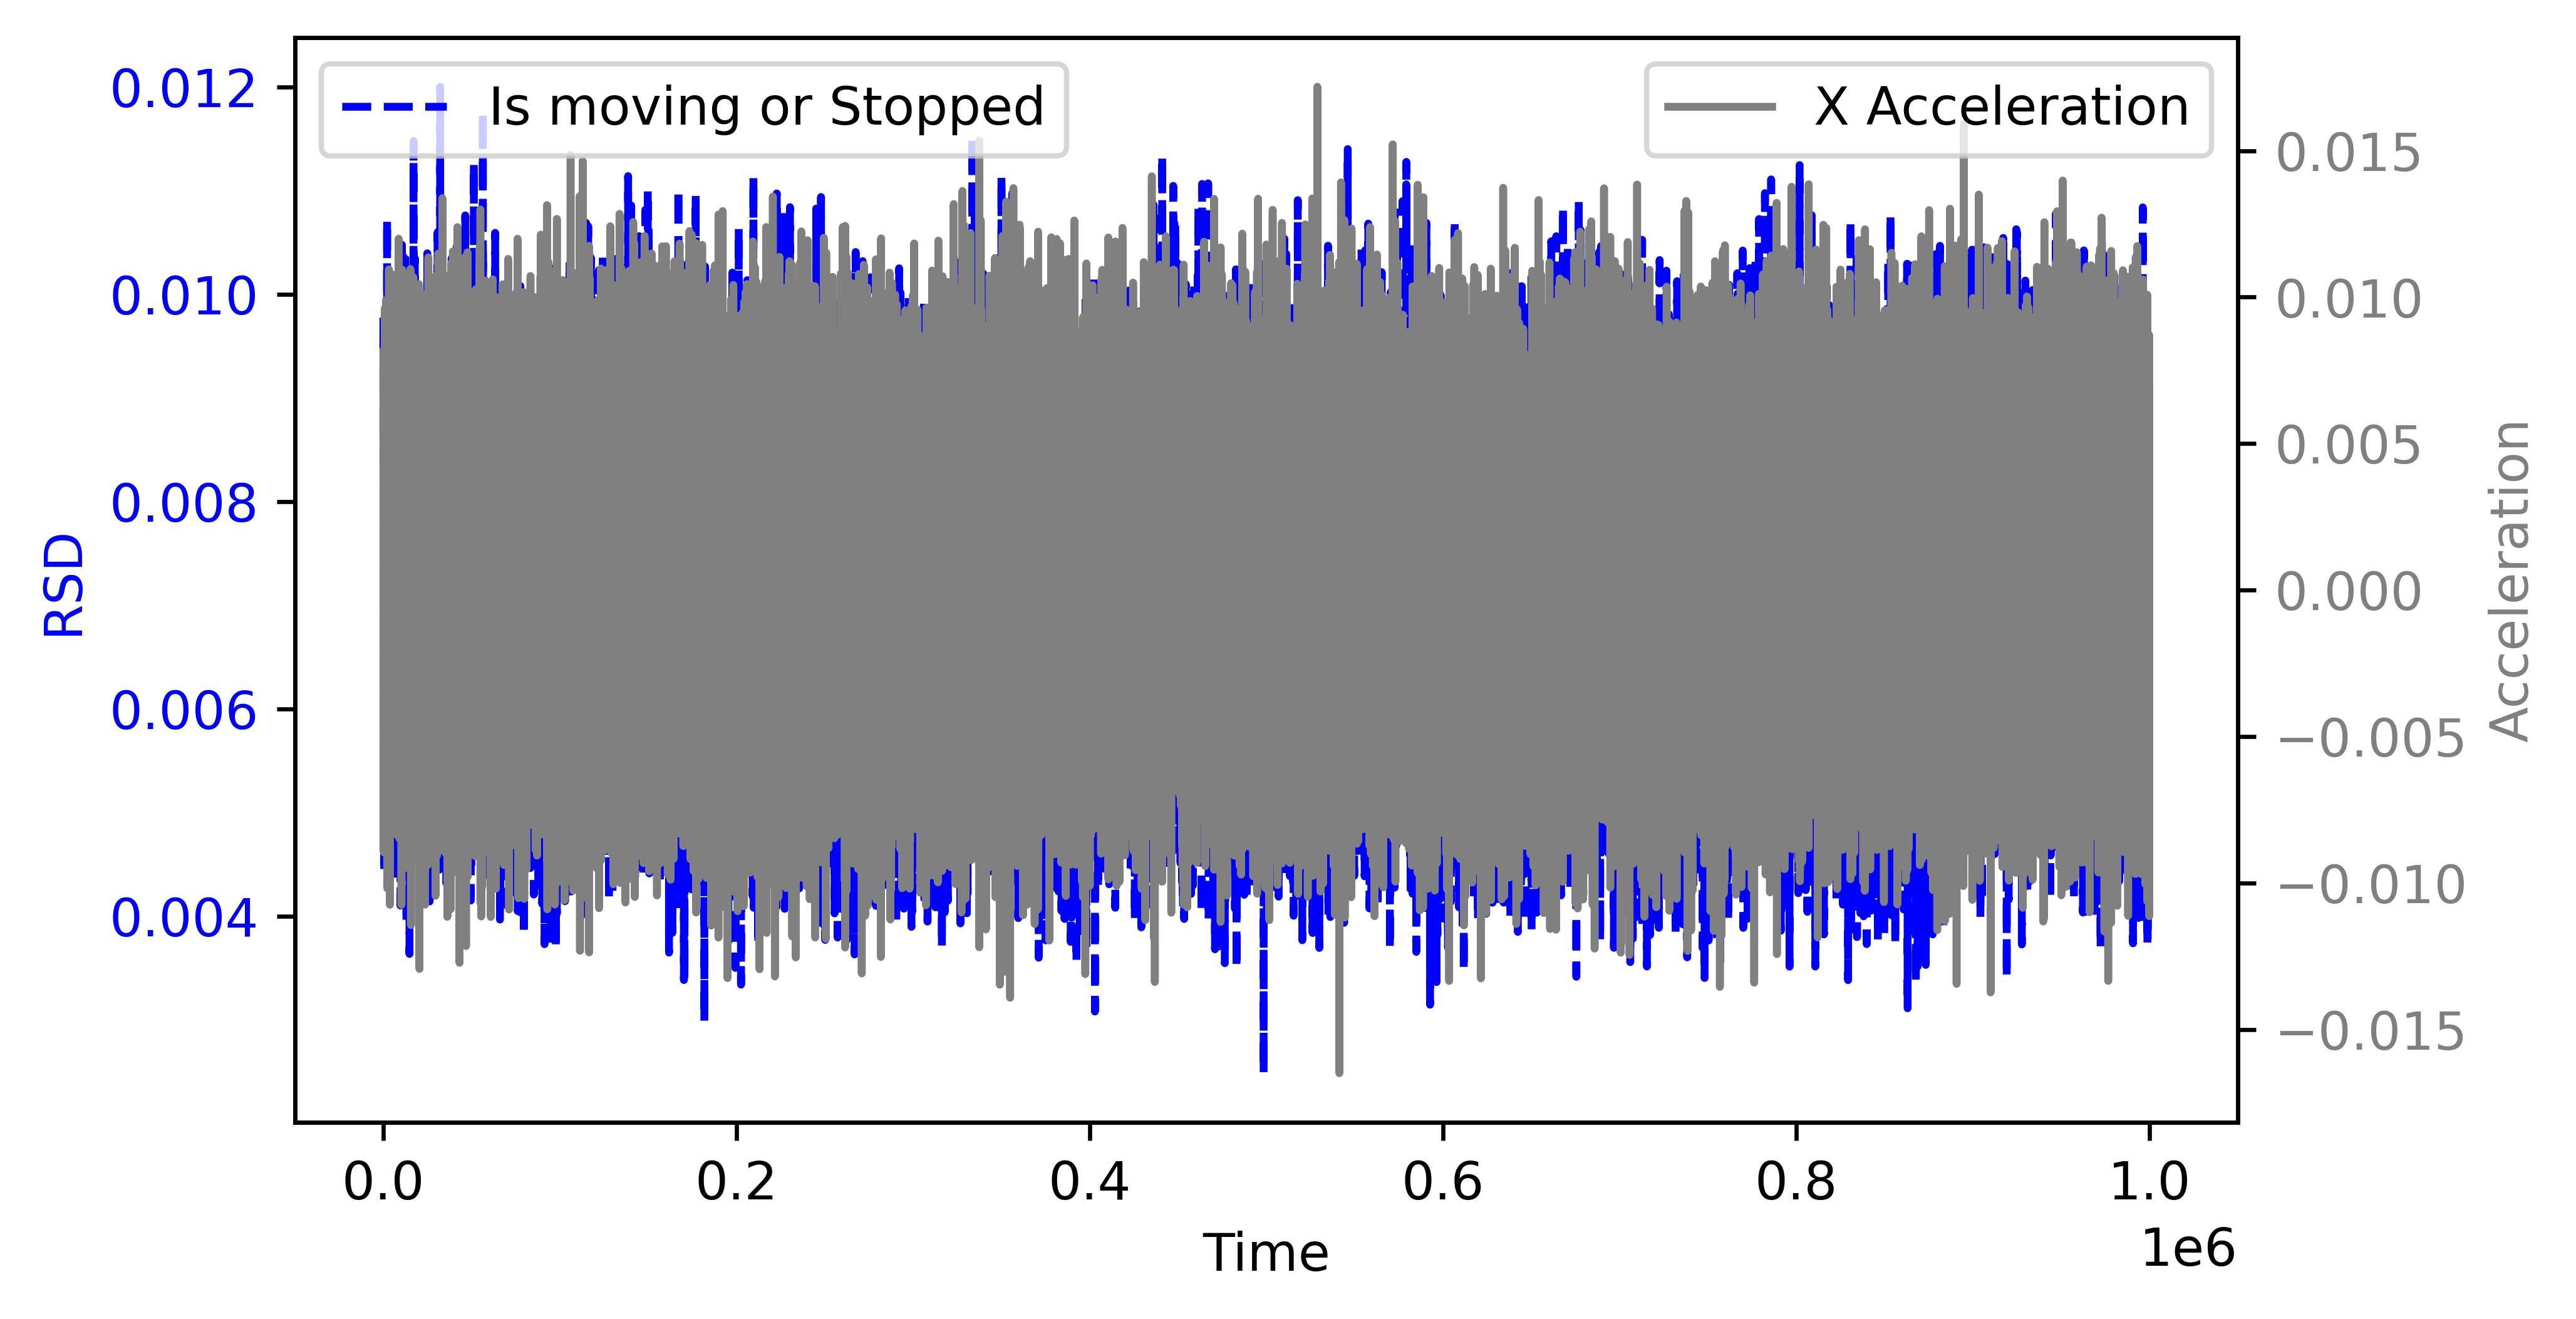

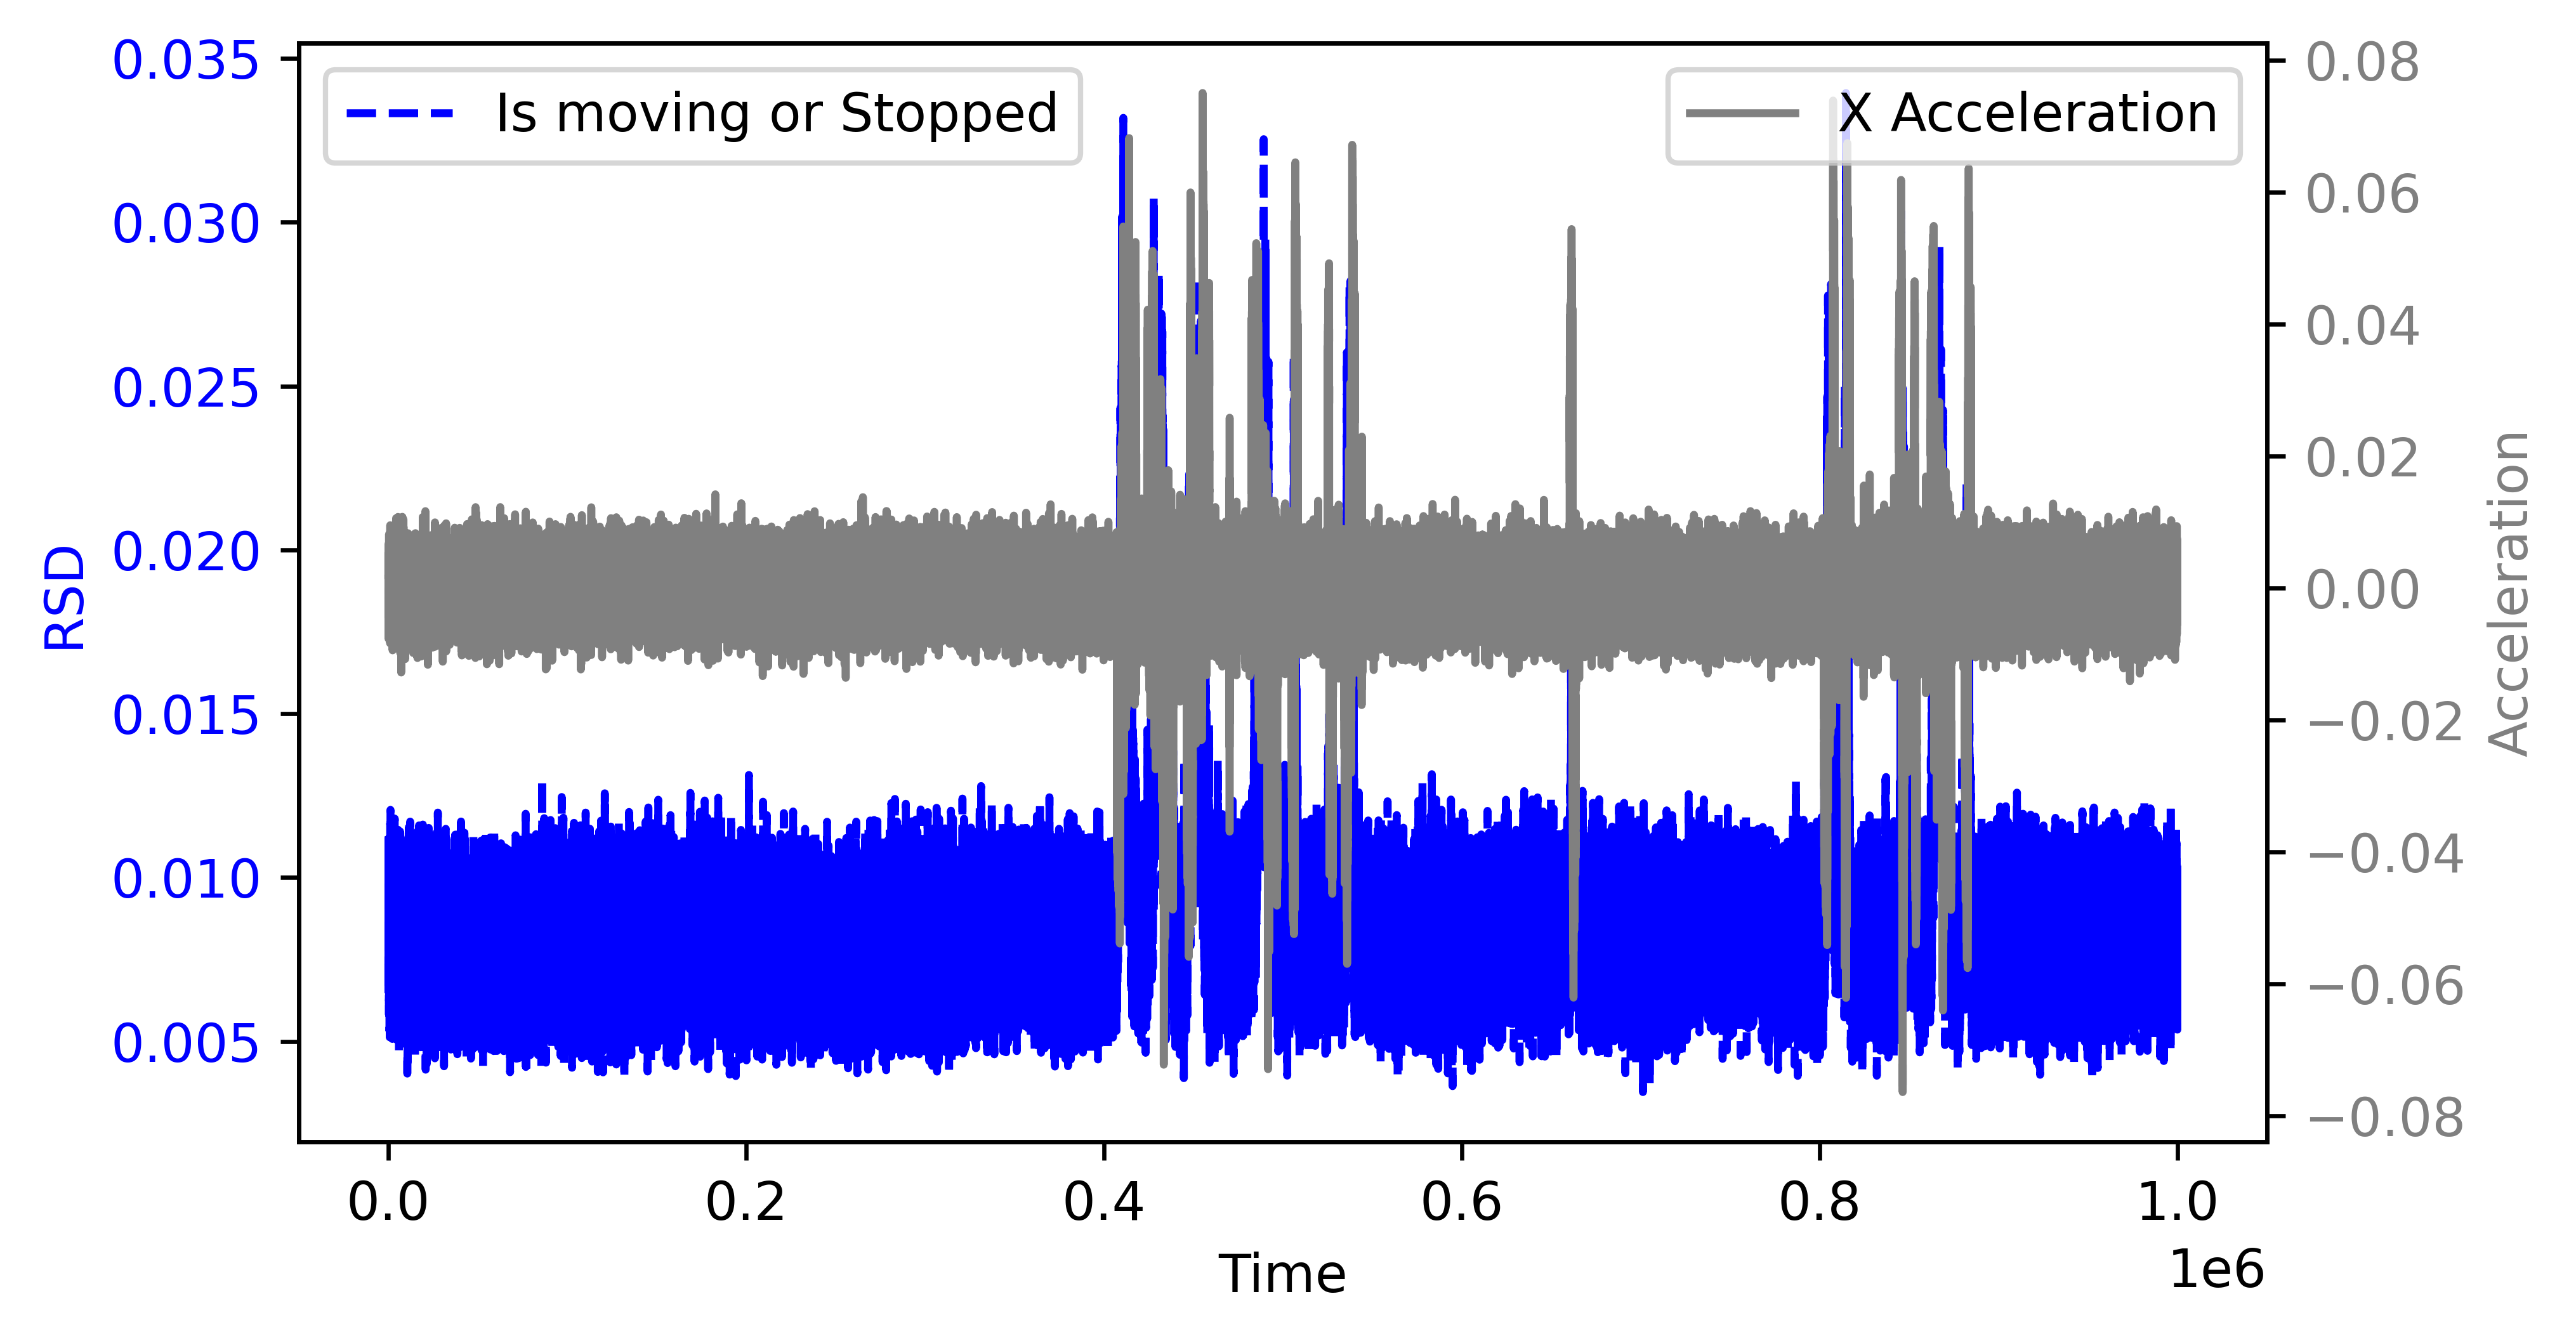

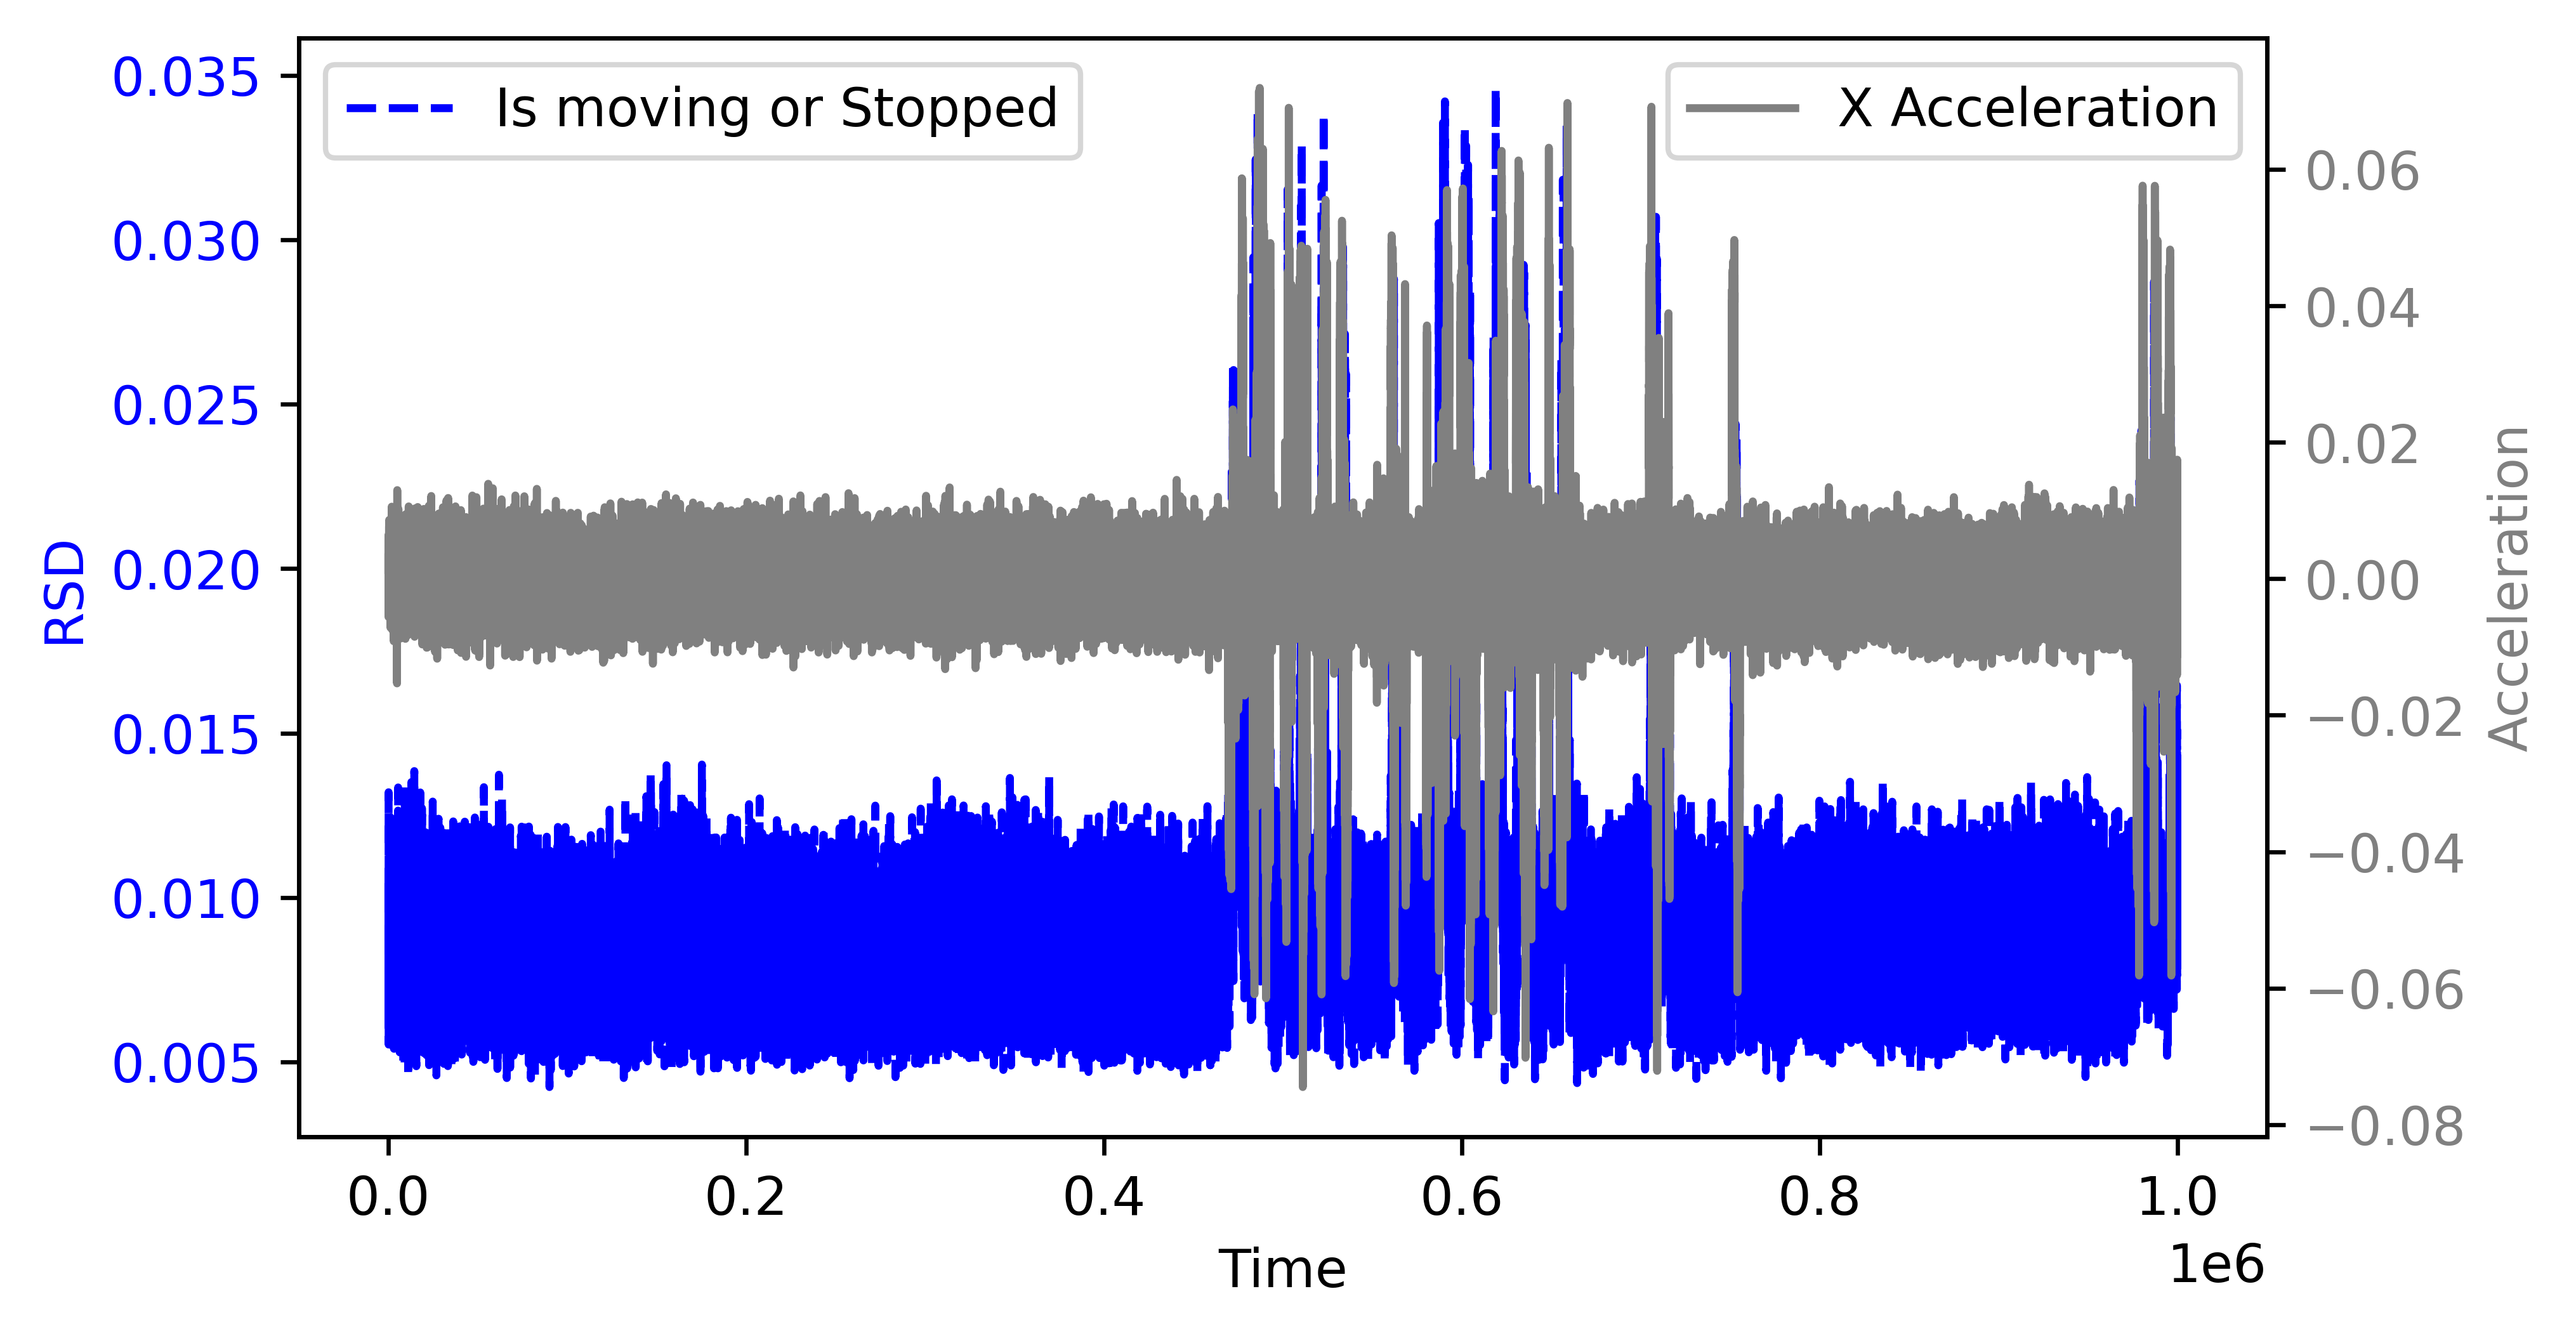

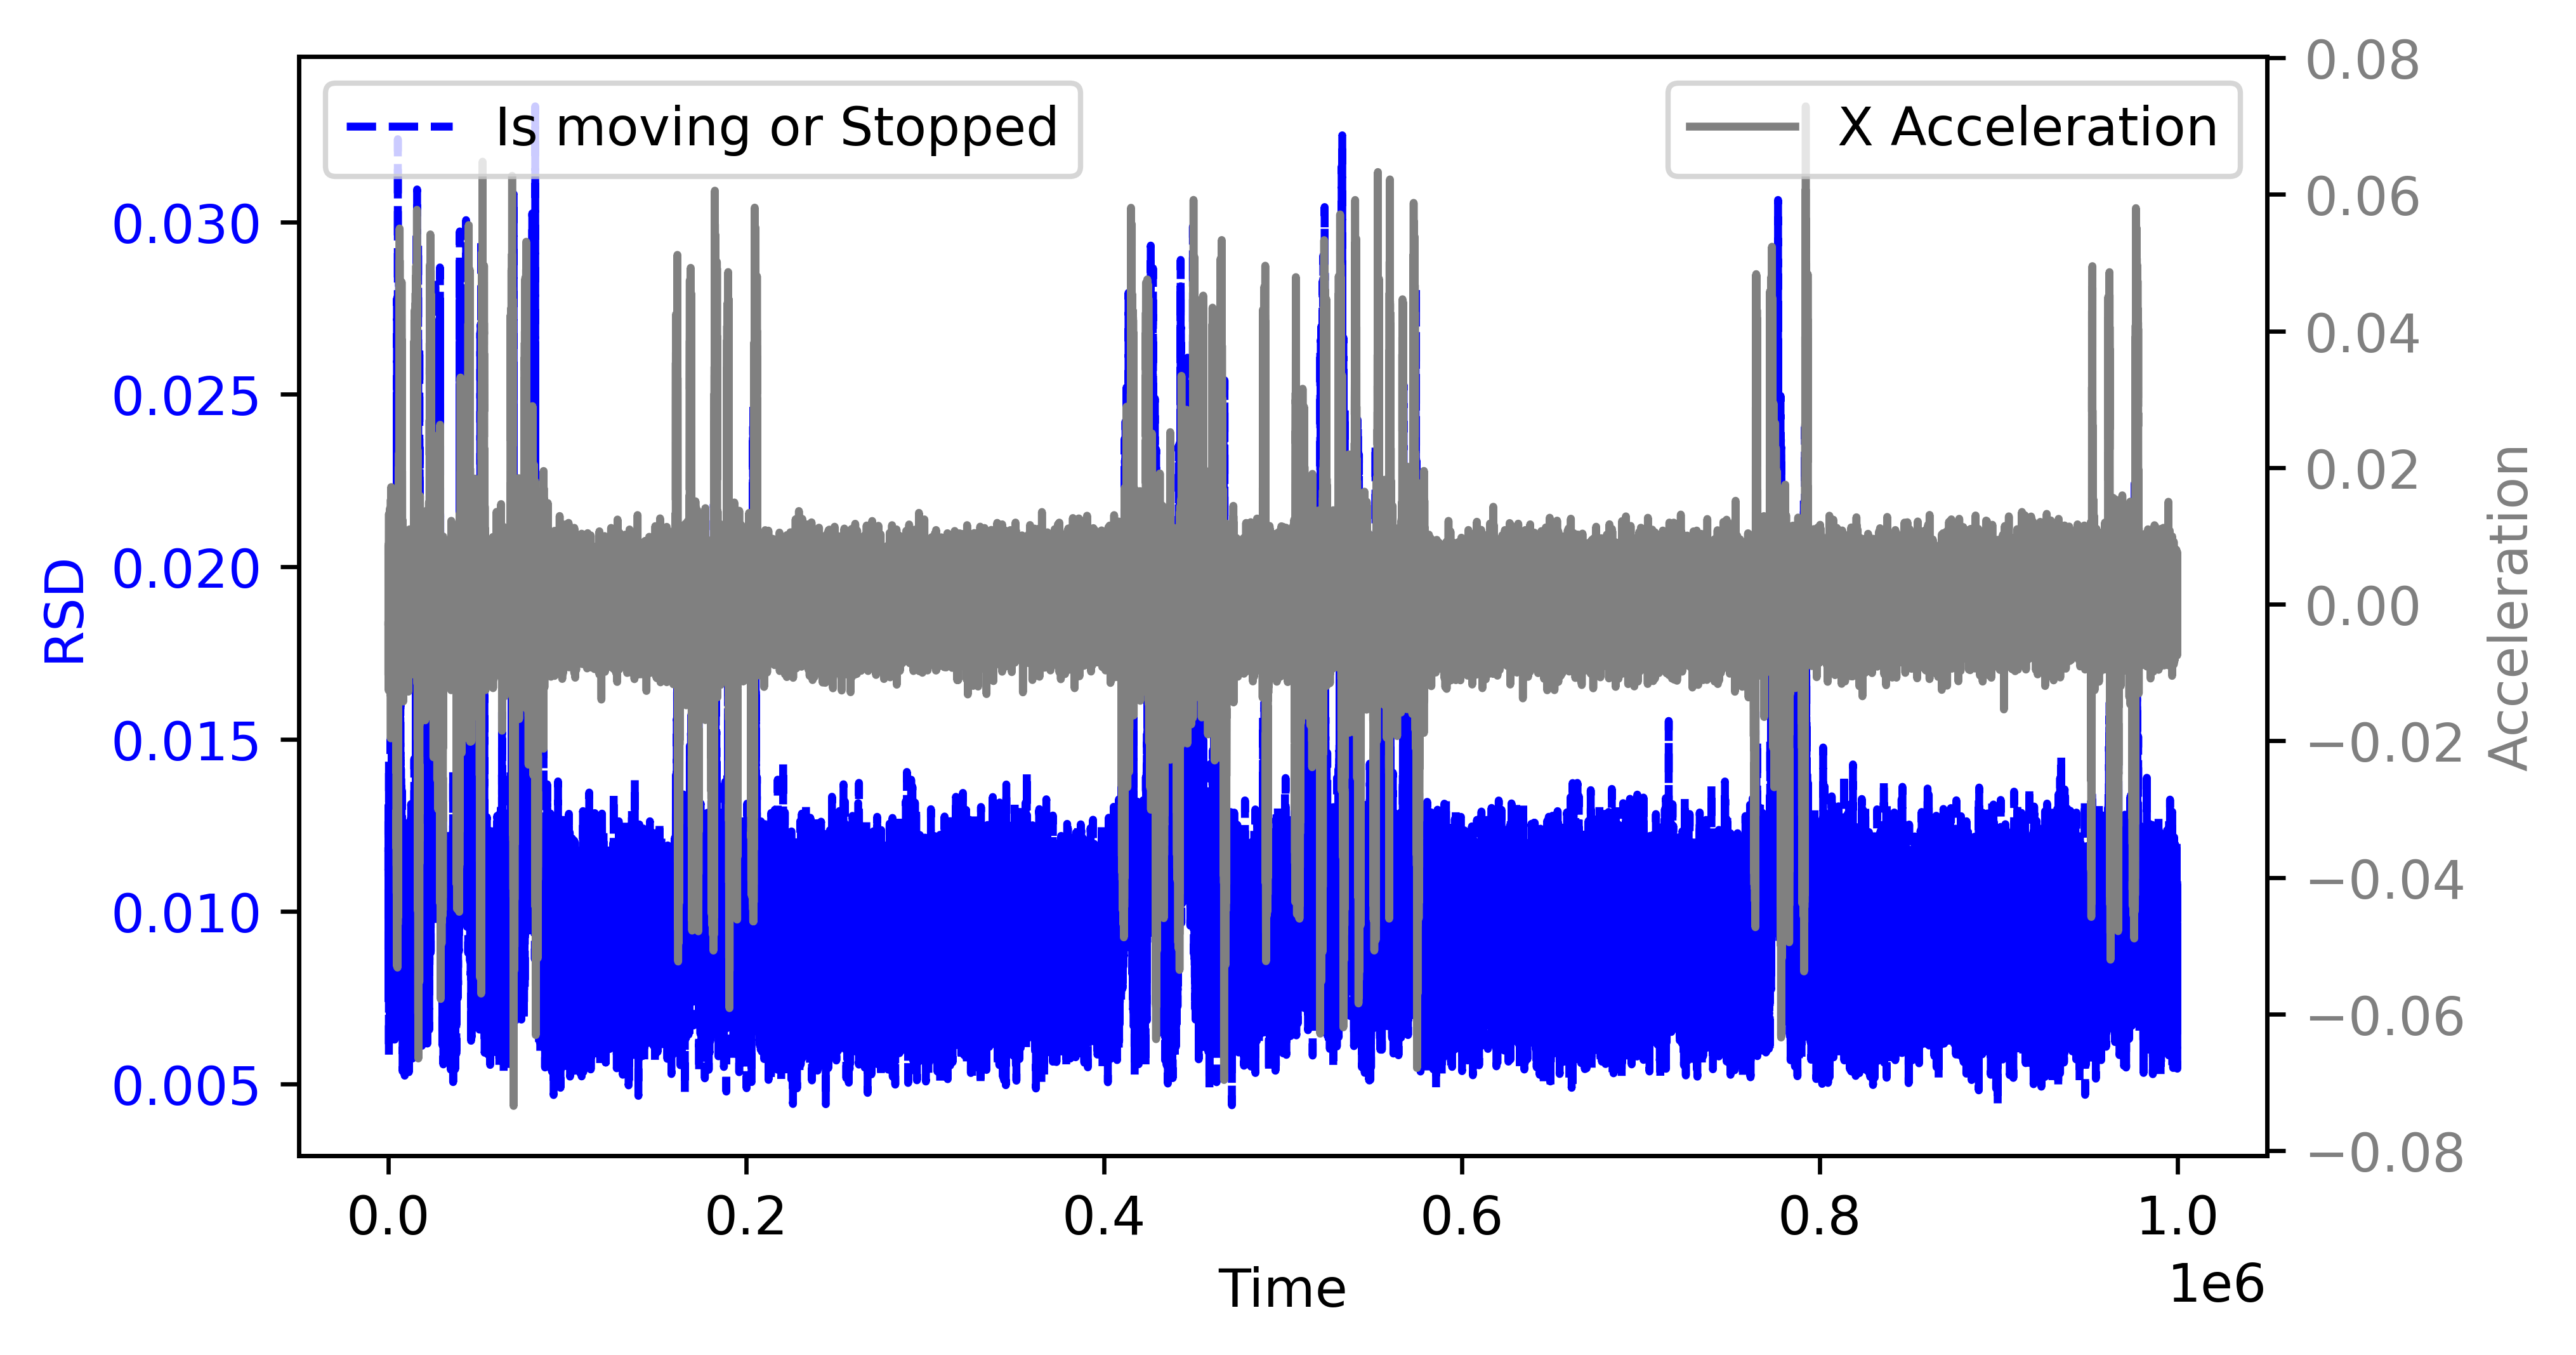

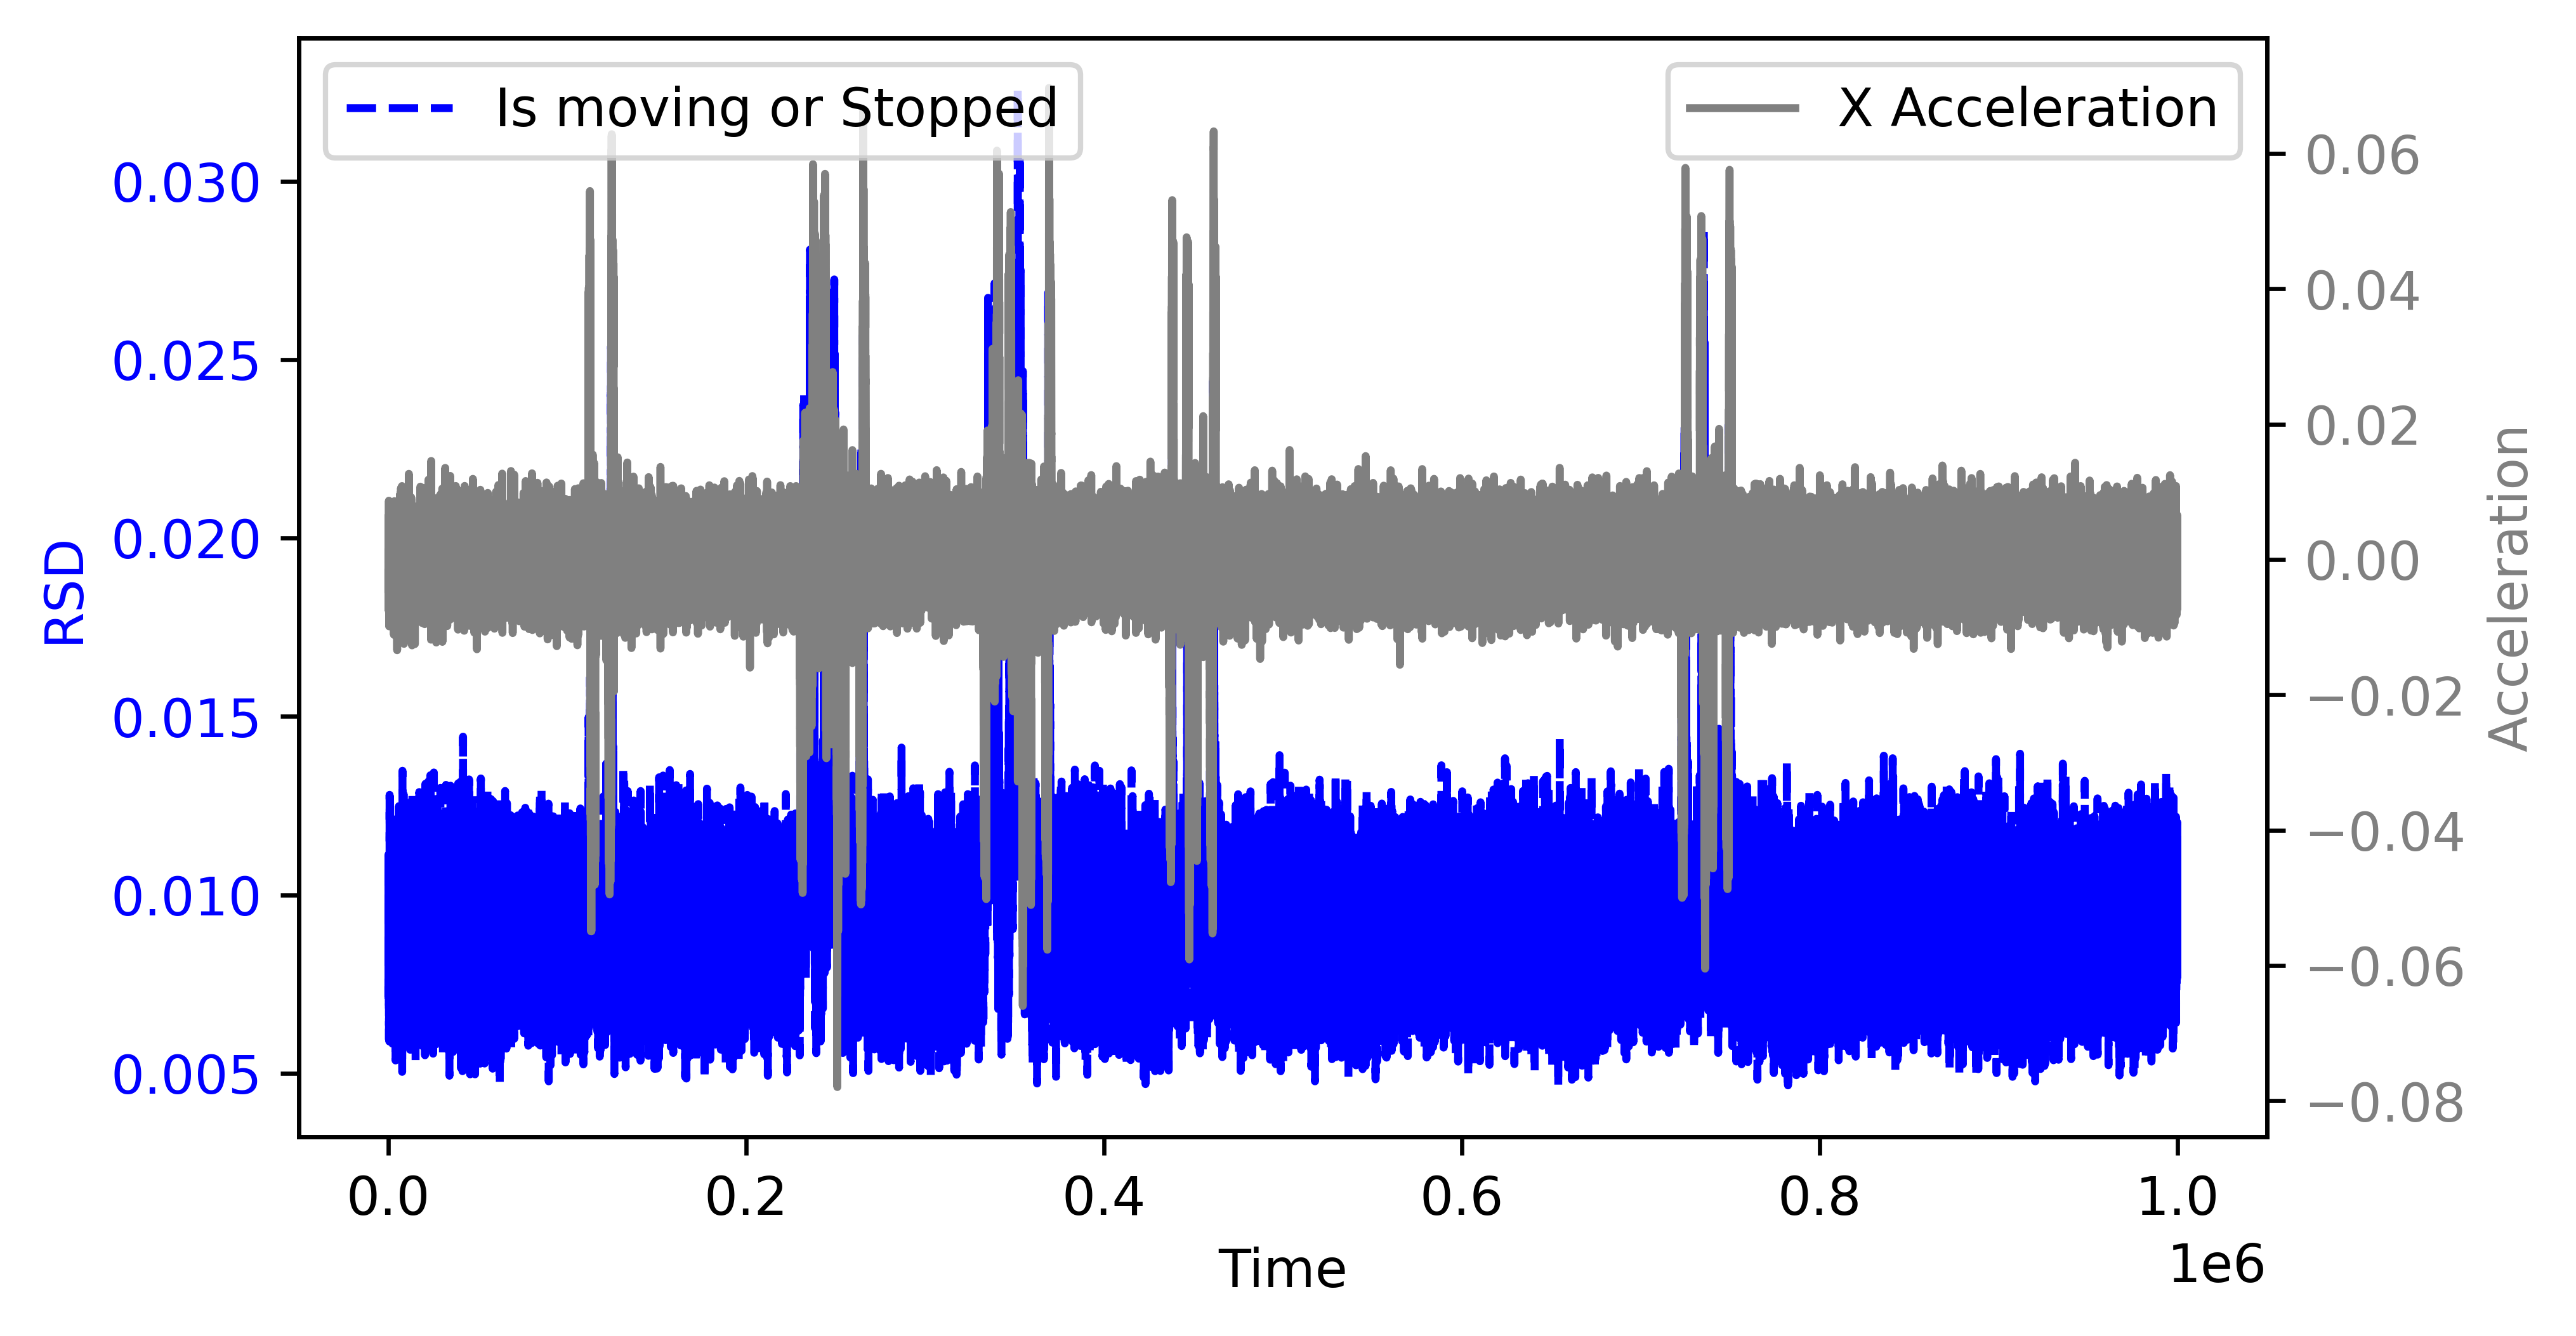

In [38]:
#f=1
d=2


start = 3000000

for f in range(len(Moves)):
    fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=600,linewidth=0.5) 

    # PlotLength = min(len(SquelchSignals[f][d]), np.shape(RawData[f])[d])
    PlotLength = 1000000

    end = start + PlotLength

    v = StdDevs[f][0][start:end]
    sd = Moves[f][0][0].T[start:end]
    
    #v+=1

    ax1.set_xlabel('Time') 
    ax1.set_ylabel('RSD', color = 'blue') 
    ax1.plot(range(PlotLength), v, color = 'blue', linestyle = 'dashed', label='Is moving or Stopped' )
    ax1.tick_params(axis ='y', labelcolor = 'blue') 
    #plt.ylim(-6,6)
    legend_1 = ax1.legend(loc=2)
    legend_1.remove()

    # Adding Twin Axes

    ax2 = ax1.twinx() 

    ax2.set_ylabel('Acceleration', color = 'grey') 
    ax2.plot(range(PlotLength), sd, color = 'grey', label='X Acceleration') 
    ax2.tick_params(axis ='y', labelcolor = 'grey') 
    #plt.ylim(0.0,0.6)
    ax2.legend(loc=1)
    ax2.add_artist(legend_1)
    # Show plot

    plt.show()

In [ ]:
SSs=[]
Vels=[]

for f in range(len(Moves)):
    SquelchSignal = SquelchPattern(StdDevs[f][0], 1500, 0.015)
    Velocity = getVelocity(Moves[f][2][0].T, times[f], SquelchSignal, 2)
    SSs.append(SquelchSignal)
    Vels.append(Velocity)
    print(k, (ti()-st)/60.0)

In [ ]:

start = 3000000

for f in range(len(Moves)):
    fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=600,linewidth=0.5) 

    # PlotLength = min(len(SquelchSignals[f][d]), np.shape(RawData[f])[d])
    PlotLength = 1000000

    end = start + PlotLength

    v = Vels[f][start:end]
    sd = Moves[f][0][0].T[start:end]
    
    #v+=1

    ax1.set_xlabel('Time') 
    ax1.set_ylabel('Velocity', color = 'red') 
    ax1.plot(range(PlotLength), v, color = 'red', linestyle = 'dashed', label='Is moving or Stopped' )
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    #plt.ylim(-6,6)
    legend_1 = ax1.legend(loc=2)
    legend_1.remove()

    # Adding Twin Axes

    ax2 = ax1.twinx() 

    ax2.set_ylabel('Acceleration', color = 'grey') 
    ax2.plot(range(PlotLength), sd, color = 'grey', label='X Acceleration') 
    ax2.tick_params(axis ='y', labelcolor = 'grey') 
    #plt.ylim(0.0,0.6)
    ax2.legend(loc=1)
    ax2.add_artist(legend_1)
    # Show plot

    plt.show()

In [ ]:
def SepreateMovements(SquelchSignal, RawData):
    Moves= []
    Move = np.zeros((1,3), dtype=float)
    for j in range(len(SquelchSignal)-1):
        if SquelchSignal[j] == 1:
            try:
                Move = np.concatenate((Move, RawData[j,:]), axis=0)
            except:
                print(j)
            if SquelchSignal[j+1] == 0:
                #Move = np.matrix(Move)
                Moves.append(Move)
                Move = np.zeros((1,3), dtype=float)
                #Move[0,2]=0
    Moves.append(Move)
    return Moves
    

In [ ]:
for i in range(len(RawData)):
    print(len(SquelchSignal[i]), len(RawData[i]))

In [ ]:
Movements = Parallel(n_jobs=31)(delayed(SepreateMovements)(SquelchSignal[i], RawData[i])
                                       for i in range(len(RawData)))

In [ ]:
Moves=[]
for Groups in Movements:
    for Move in Groups:
        Moves.append(Move)

In [ ]:
len(Moves)

In [ ]:
del SquelchSignal
del RawData

In [ ]:
def splitLong(Moves, maxLength = 4000, minLength = 1000):
    Xmoves = []
    for move in Moves:
        if np.shape(move)[0] > maxLength: 
            Xmoves.append(move[:int(len(move)/2),:])
            Xmoves.append(move[int(len(move)/2):,:])
        else:
            if np.shape(move)[0] < minLength:
                pass
            else:
                Xmoves.append(move)
    return Xmoves

def findMaxLength(Moves):
    maxLength = 0
    LongMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] > maxLength: 
            maxLength =  np.shape(Moves[i])[0]
            LongMove = i
    return maxLength, LongMove

def findMinLength(Moves):
    minLength = 9999999
    SmallMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] < minLength: 
            minLength =  np.shape(Moves[i])[0]
            SmallMove = i
    return minLength, SmallMove


In [ ]:
longMove, MoveNumb = findMaxLength(Moves)

In [ ]:
print(longMove, MoveNumb)

In [ ]:
MoveNum = MoveNumb

In [ ]:
scales= 100
skips = 1
wvlt = 'coif'


wvlt = 'beta'

WvltFam = py.families()
Wvlts = []
for Fam in WvltFam:
    temp = py.wavelist(Fam)
    for wvlt in temp:
        Wvlts.append(wvlt)
        
trys = Wvlts

#'sym1','sym2','sym3','db1','db2']
trys = ['mexh','haar','gaus1','morl','gaus2','gaus8','beta','coif2','coif8','db2','db8','sym2','sym8']

In [ ]:
len(trys)

In [ ]:
def MaxSpectrogram(Signal,i=0,Save=True):
    
    plt.specgram(Signal, Fs=6, cmap="rainbow")

    # Set the title of the plot, xlabel and ylabel
    # and display using show() function
    plt.title('Spectrogram Using matplotlib.pyplot.specgram() Method')
    plt.xlabel("DATA")
    plt.ylabel("TIME")
    if Save: plt.savefig(imageFolder+'specgram/Move '+str(i).zfill(4)+'.png')
    plt.show()
    
    return 0

In [ ]:
Moves = splitLong(Moves, longMove+1)

In [ ]:
f = 0
for i in range(len(Moves)):
    if f == 0:
        if abs(np.shape(Moves[i])[0] - 2000) < 50:
            print(i)
            f = 1
            MoveNum = i

np.shape(Moves[MoveNum][:,0])

In [ ]:
print(findMinLength(Moves))

In [ ]:
#wvlt = 'beta'
#FPimages = Parallel(n_jobs=60)(delayed(cf.makeMPFast)(Moves[i].T, wvlt, scales, skips,imageFolder+'org-beta/Move'+str(i).zfill(4)) for i in range(len(Moves)))

FPimages = Parallel(n_jobs=60)(delayed(cf.makeMPFast)(Moves[MoveNum].T, tri, scales, skips, '',True) for tri in trys)

In [ ]:
np.shape(FPimages[12])

In [ ]:
np.shape(Moves[MoveNum][:,0].flatten())

In [ ]:
ThreeColor = cf.makeMPFast(Moves[MoveNum].T, 'morl', scales, skips)
dataX = cf.getThumbprint2(Moves[MoveNum][:,0].flat, 'morl', scales, skips)
dataY = cf.getThumbprint2(Moves[MoveNum][:,1].flat, 'morl', scales, skips)
dataZ = cf.getThumbprint2(Moves[MoveNum][:,2].flat, 'morl', scales, skips)


In [ ]:
xName = np.arange(0,np.shape(dataX)[0],1)
Al,Ms  = np.meshgrid(xName,np.linspace(1,scales,scales))


fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(17,11), dpi=900, gridspec_kw={'height_ratios':[1,1,1,1,1]})
ax[0].margins(0)
ax[0].plot(Moves[MoveNum][:,0])
ax[0].plot(Moves[MoveNum][:,1])
ax[0].plot(Moves[MoveNum][:,2])

ax[1].contourf(Al,Ms, dataX[:,:].T,cmap=my_cmap,levels=2)
ax[2].contourf(Al,Ms, dataY[:,:].T,cmap=my_cmap,levels=2)
ax[3].contourf(Al,Ms, dataZ[:,:].T,cmap=my_cmap,levels=2)

ax[4].imshow(np.flipud(ThreeColor))
#ax[4].contourf(Al,Ms, np.flipud(ThreeColor))
ax[4].set_aspect(aspect=2)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=1,figsize=(17,11), dpi=800,gridspec_kw={'height_ratios':[2,1,1,1,1,1,1,1,1,1]})
ax[0].margins(0)
ax[0].plot(Moves[MoveNum][:,0])
ax[0].plot(Moves[MoveNum][:,1])
ax[0].plot(Moves[MoveNum][:,2])

#trys =  ['mexh','haar','gaus1','morl','gaus2','gaus8','beta','coif2','coif8','db2','db8','sym2','sym8']
show = ['','beta','gaus2','gaus8','coif2','coif8','db2','db8','sym2','sym8']

ax[1].imshow(np.flipud(FPimages[trys.index(show[1])]))
ax[2].imshow(np.flipud(FPimages[trys.index(show[2])]))
ax[3].imshow(np.flipud(FPimages[trys.index(show[3])]))
ax[4].imshow(np.flipud(FPimages[trys.index(show[4])]))
ax[5].imshow(np.flipud(FPimages[trys.index(show[5])]))
ax[6].imshow(np.flipud(FPimages[trys.index(show[6])]))
ax[7].imshow(np.flipud(FPimages[trys.index(show[7])]))
ax[8].imshow(np.flipud(FPimages[trys.index(show[8])]))
ax[9].imshow(np.flipud(FPimages[trys.index(show[9])]))

ax[1].set_ylabel(show[1])
ax[2].set_ylabel(show[2])
ax[3].set_ylabel(show[3])
ax[4].set_ylabel(show[4])
ax[5].set_ylabel(show[5])
ax[6].set_ylabel(show[6])
ax[7].set_ylabel(show[7])
ax[8].set_ylabel(show[8])
ax[9].set_ylabel(show[9])

ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[2].axes.get_xaxis().set_visible(False)
ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[3].axes.get_xaxis().set_visible(False)
ax[3].set_yticklabels([])
ax[3].set_yticks([])
ax[4].axes.get_xaxis().set_visible(False)
ax[4].set_yticklabels([])
ax[4].set_yticks([])
ax[5].axes.get_xaxis().set_visible(False)
ax[5].set_yticklabels([])
ax[5].set_yticks([])
ax[6].axes.get_xaxis().set_visible(False)
ax[6].set_yticklabels([])
ax[6].set_yticks([])
ax[7].axes.get_xaxis().set_visible(False)
ax[7].set_yticklabels([])
ax[7].set_yticks([])
ax[8].axes.get_xaxis().set_visible(False)
ax[8].set_yticklabels([])
ax[8].set_yticks([])
ax[9].axes.get_xaxis().set_visible(False)
ax[9].set_yticklabels([])
ax[9].set_yticks([])

plt.show()

In [ ]:
maxDesiredLength = 4000

while findMaxLength(Moves)[0] > maxDesiredLength:
    Moves = splitLong(Moves, maxDesiredLength)

In [ ]:
spectrum, freqs, t, im = plt.specgram(np.asarray(Moves[MoveNum][:,0]), Fs=6, cmap="rainbow")

In [ ]:
import scipy as ss
def MakeSpectrogramImages(data, title, something=300, nperseg = 512, novrelap=256):
    f, t, Szz = ss.signal.spectrogram(Moves[MoveNum][:,0].T,something,nperseg = nperseg, noverlap=novrelap)
    fig = plt.figure(figsize=(8,3), dpi=800)
    ax = plt.axes()
    ax.set_axis_off()
    plt.pcolormesh(t, f, Szz[0],cmap='gist_ncar')
    plt.savefig(imageFolder+'specgram/'+title+'.png',bbox_inches='tight', pad_inches=0)

In [ ]:
FPimages = Parallel(n_jobs=60)(delayed(MakeSpectrogramImages)(Moves[i].T, 'Move'+str(i).zfill(4), 300, 512, 505) for i in range(len(Moves)))

In [ ]:
x = [''  for x in range(10)]

In [ ]:
import CoreFunctions as CF

fig = plt.figure()
plt.plot(CF.BetaWavelet(100,sineCycle=4)[0])
plt.plot(CF.BetaWavelet(100,sineCycle=3)[0])
plt.plot(CF.BetaWavelet(100,sineCycle=2)[0])
plt.show()